In [13]:
from astropy import constants
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
import matplotlib as mpl
import scipy 
from scipy.fft import fft, fftshift
from astropy.units import Quantity
import matplotlib.ticker as ticker
import cmcrameri.cm as cmc
import sys

from pyuvdata import UVData
from uvtools.dspec import gen_window
from uvtools.plot import waterfall
from uvtools.utils import FFT, fourier_freqs

from astropy import units as u
mpl.rcParams['font.size']=20
from plotting_functions import plot_waterfalls,plot_waterfalls_from_dlfr
from functions import covariance_from_pspec,sys_modes,fourier_operator,data_fr_dly_to_t_f

# Setup

In [24]:
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
plt.rcParams.update({'font.size': 30})

In [4]:
# Check power spectrum
def calc_ps(s):
    # NOTE: This uses inverse FFT instead of FFT to get the right normalisation
    axes = (1,)
    sk = np.fft.ifftshift(s, axes=axes)
    sk = np.fft.fftn(sk, axes=axes)
    sk = np.fft.fftshift(sk, axes=axes)
    Nobs, Nfreqs = sk.shape
    return np.mean(sk * sk.conj(), axis=0).real / Nfreqs # CHECK: This takes an average

In [5]:
result_dir='../paper_plots/'
# run_version = 'low_dl_fr_0'
run_version = 'high_dl_fr_0'
# run_version = 'low_dl_low_fr'
# run_version = 'fixed_sky'

# Build systematics model
# nm_list = [(3,0),(4,0),(5,0),(6,0)] #low dl fr 0
nm_list = [(10,0), (11,0), (12,0), (13,0)] #high dl fr 0
# nm_list = [(3,3),(3,4),(3,5),(3,6)] #low dl low fr

In [14]:
Ntimes = 80 #60 #203
Nfreqs = 60
freqs = np.linspace(100., 120., 120) ##120) 
Nfgmodes = 12
freqs = freqs[:Nfreqs]
# Generate FG mode matrix
fgmodes = np.array([
                scipy.special.legendre(i)(np.linspace(-1., 1., freqs.size))
                for i in range(Nfgmodes)
            ]).T

lsts = np.linspace(0., 1., Ntimes)
sys_modes_operator = sys_modes(freqs_Hz=freqs*1e6, 
                                    times_sec=lsts * 24./(2.*np.pi) * 3600., 
                                    modes=nm_list)

sys_amps_true = np.array([4., 4.1, 5., -2.]) #np.array([4., 4.01])
sys_prior = 4**2. * np.eye(sys_amps_true.size)

fourier_op = fourier_operator(freqs.size, unitary=True)

# Generate noise
noise_ps_val = 0.000004 #0.000004 # 0.0004
noise_ps_true = noise_ps_val * np.ones(freqs.size)
N_true = covariance_from_pspec(noise_ps_true, fourier_op)
Ninv = np.diag(1./np.diag(N_true)) # get diagonal, invert, pack back into diagonal
n = np.sqrt(N_true) @ (np.random.randn(freqs.size, Ntimes) 
                    + 1.j*np.random.randn(freqs.size, Ntimes)) / np.sqrt(2.)
# Note factor of sqrt(2) above
noise_ps_check = calc_ps(n.T)

# Plotting the delay power spectra

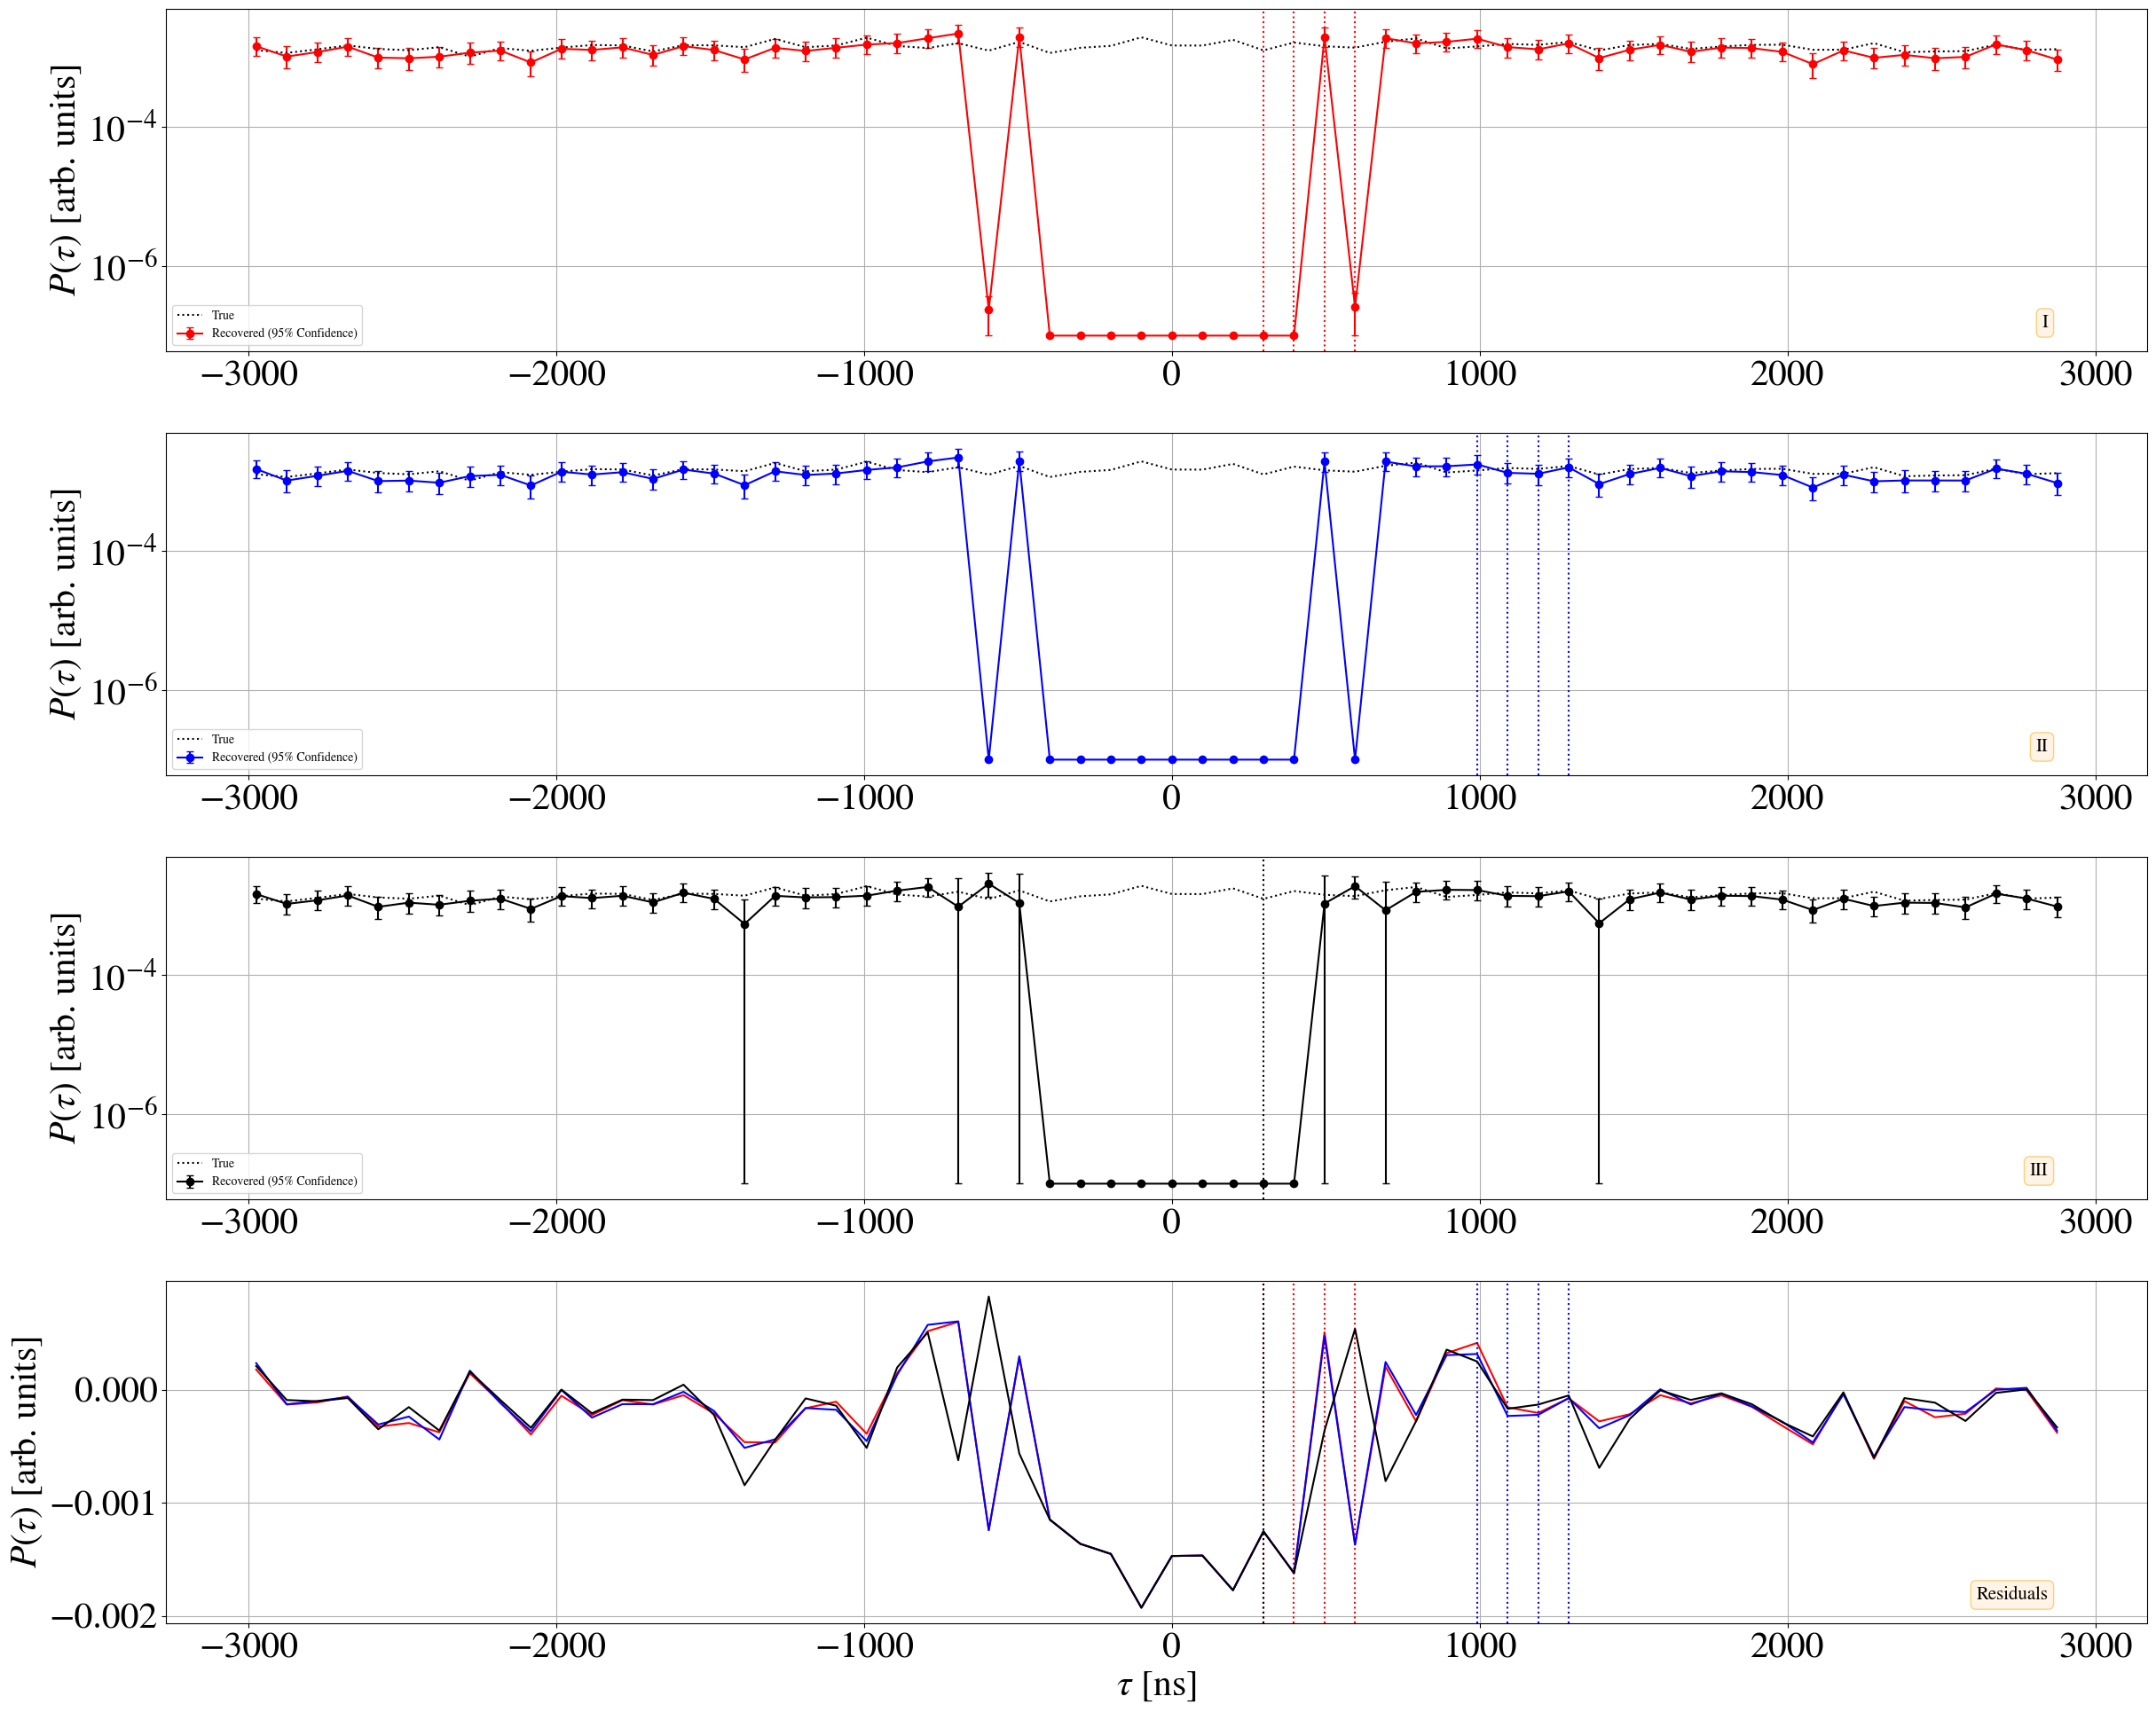

In [27]:
result_dir='../paper_plots/'
run_version_arr = ['low_dl_fr_0','high_dl_fr_0','low_dl_low_fr']
# run_version_arr = ['high_dl_fr_0','masked_data','filtered_data']

conf_interval=95
Nburn = 10

fig_labels=['I','II','III','Residuals']
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)

dl_inds=[[3,4,5,6],[10,11,12,13],[3,3,3,3]]
fig, ax = plt.subplots(4,1,figsize=(25, 20))
i=0
colors=['r','b','k']
for run_version in run_version_arr:
    eor_true=np.load(result_dir+run_version+'/eor_true.npy')
    ps_sample = np.load(result_dir+run_version+'/dps-eor.npy')
    ln_post = np.load(result_dir+run_version+'/ln-post.npy')
    ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])
    ps_mean = np.mean(ps_sample, axis=0)
    df = (freqs[1] - freqs[0]) * u.MHz
    delays = np.fft.fftshift(np.fft.fftfreq(Nfreqs, d=df.to("1/ns")))

    sys_delays= delays[np.unique(dl_inds[i])+int(Nfreqs/2)].value
    if Nburn > 0:
        ps_sample = ps_sample[Nburn:]
        ln_post = ln_post[Nburn:]
    # Posterior-weighted mean delay power spectrum
    dps_eor_hp_pwm = np.average(ps_sample, weights=ln_post, axis=0)
    
    # Confidence interval of delay power spectrum posteriors
    percentile = conf_interval/2 + 50
    dps_eor_hp_ubound = np.percentile(ps_sample, percentile, axis=0)
    dps_eor_hp_lbound = np.percentile(ps_sample, 100-percentile, axis=0)
    dps_eor_hp_err = np.vstack((
        dps_eor_hp_pwm - dps_eor_hp_lbound,
        dps_eor_hp_ubound - dps_eor_hp_pwm
    ))
    
    ax[i].errorbar(
                    delays,
                    dps_eor_hp_pwm,
                    yerr=np.abs(dps_eor_hp_err),
                    color=colors[i],
                    # ls="",
                    marker="o",
                    capsize=3,
                    label=f"Recovered ({conf_interval}% Confidence)"
                    )
    ax[i].plot(delays, ps_true, "k:", label="True")

    ax[i].legend(loc="best",fontsize=10)
    ax[i].set_ylabel(r"$P(\tau)$ [arb. units]")
    # ax.set_title("EoR Delay Power Spectrum Comparison")
    ax[i].set_yscale("log")
    ax[i].grid()
    ax[i].text(0.95,0.07,fig_labels[i],fontsize=15, bbox=bbox,
            transform=ax[i].transAxes, horizontalalignment='right')
    for dl in sys_delays:
        
        ax[i].axvline(dl,ls='dotted',c=colors[i])
        ax[3].axvline(dl,ls='dotted',c=colors[i])


    ax[3].plot(delays,(dps_eor_hp_pwm-ps_true),color=colors[i])
    ax[3].set_ylabel(r"$P(\tau)$ [arb. units]")
    ax[3].set_xlabel(r'$\tau$ [ns]')
    ax[3].grid()

    i=i+1

ax[-1].text(0.95,0.07,fig_labels[-1],fontsize=15, bbox=bbox,
            transform=ax[-1].transAxes, horizontalalignment='right')

fig.tight_layout()
plt.savefig(result_dir+'/delay_power_spectrum.pdf',bbox_inches='tight',dpi=300)


# Plotting the different systematic locations in DL FR space

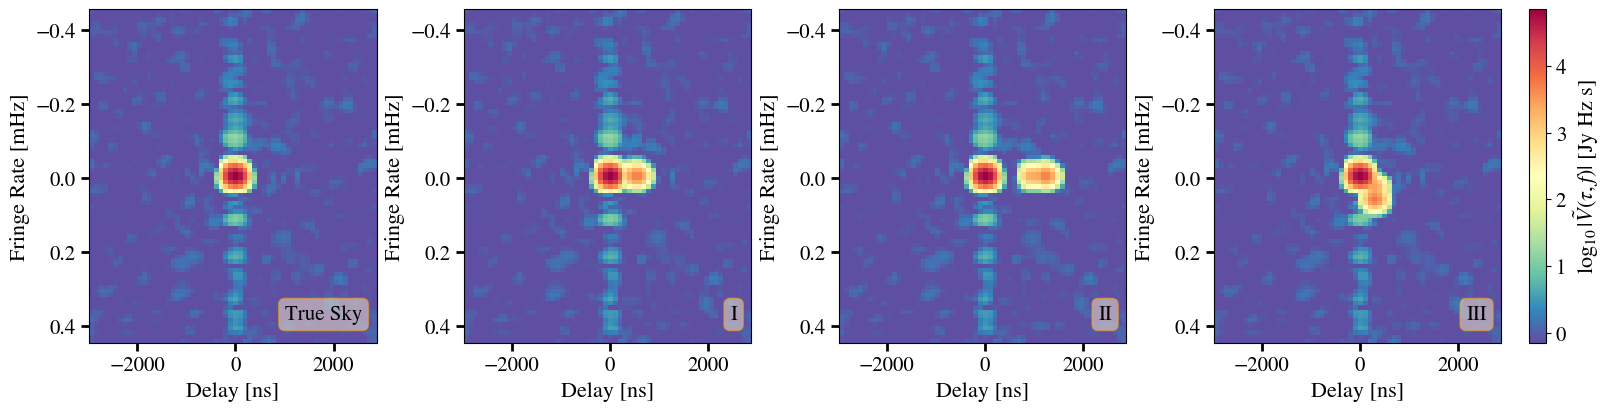

In [32]:
result_dir='../paper_plots/'
run_version_arr = ['low_dl_fr_0','high_dl_fr_0','low_dl_low_fr']

nm_list_arr = [
            [(3,0),(4,0),(5,0),(6,0)],
            [(10,0), (11,0), (12,0), (13,0)],
            [(3,3),(3,4),(3,5),(3,6)]
            ]

fig,axs = plt.subplots(1,4,layout="constrained",figsize=(16,4))
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
i=0

eor_true=np.load(result_dir+run_version_arr[0]+'/eor_true.npy')
fg_true=np.load('../npy_data/fg_true.npy')
ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])
data_true = eor_true[:Ntimes,:Nfreqs] + fg_true[:Ntimes,:Nfreqs]

_=plot_waterfalls(data_true, freqs*1e6, lsts, windows='blackman-harris', fig=fig,ax=axs[0], mode='log', 
                vmin=None,vmax=None,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',colorbar_flag=False,
                freq_window_kwargs=None, time_window_kwargs=None)
axs[0].text(0.95,0.07,'True Sky',fontsize=15, bbox=bbox,
            transform=axs[0].transAxes, horizontalalignment='right')

fig_labels = ['I','II','III']
for run_version in run_version_arr:
    sys_modes_operator = sys_modes(freqs_Hz=freqs*1e6, 
                                    times_sec=lsts * 24./(2.*np.pi) * 3600., 
                                    modes=nm_list_arr[i])
    sys_model_true= (1+sys_modes_operator @ sys_amps_true).reshape((Nfreqs, Ntimes)).T
    total_data_true = sys_model_true * data_true
    
    plot_op=plot_waterfalls(total_data_true, freqs*1e6, lsts, windows='blackman-harris', fig=fig,ax=axs[i+1], mode='log', 
                vmin=None,vmax=None,cmap='Spectral_r', dynamic_range=5, limit_drng='all', colorbar_flag=False,
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
    axs[i+1].text(0.95,0.07,fig_labels[i],fontsize=15, bbox=bbox,
            transform=axs[i+1].transAxes, horizontalalignment='right')
    i=i+1

_=fig.colorbar(plot_op[0], ax=axs, orientation='vertical', fraction=0.9, pad=0.02)
vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
_.set_label(vis_label,c='black',fontsize=16)
_.ax.tick_params(axis='y',which='both', color='black', labelcolor='black',labelsize=15)
plt.savefig(result_dir+'/'+'test_cases_in_dlfr.pdf',bbox_inches='tight',dpi=300)

In [68]:
# eor_true=np.load('/Users/user/Documents/Codes/hydra_sys_project1/multi_phil/hydra-pspec-systematic/npy_data/eor_true.npy')
eor_true=np.load(result_dir+run_version+'/eor_true.npy')
fg_true=np.load('../npy_data/fg_true.npy')
# sys_model_true=np.load(result_dir+run_version+'true_gain.npy') #1+delta_g has been saved
sys_model_true= (1+sys_modes_operator @ sys_amps_true).reshape((Ntimes, Nfreqs))
ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])

In [69]:
signal_amps = np.load(result_dir+run_version+'/gcr-eor.npy')
fg_amps = np.load(result_dir+run_version+'/fg-amps.npy').mean(axis=0)
ps_sample = np.load(result_dir+run_version+'/dps-eor.npy')
sys_amps = np.load(result_dir+run_version+'/b-sys.npy').mean(axis=0)
ln_post = np.load(result_dir+run_version+'/ln-post.npy')

In [70]:
data_true = eor_true[:Ntimes,:Nfreqs] + fg_true[:Ntimes,:Nfreqs]
model = signal_amps + fg_amps @ fgmodes.T
sys_model_sampled = (1. + sys_modes_operator @ sys_amps).reshape((Ntimes, Nfreqs))

In [71]:
total_data_true = sys_model_true * data_true

In [72]:
paper_cmap=LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#89023E-EA638C-FFD9DA
    (0.000, (0.537, 0.008, 0.243)),
    (0.500, (0.918, 0.388, 0.549)),
    (1.000, (1.000, 0.851, 0.855))))

paper_cmap_res=LinearSegmentedColormap.from_list('my_gradient', (
    # Edit this gradient at https://eltos.github.io/gradient/#89023E-EA638C-FFD9DA-EA638C-89023E
    (0.000, (0.537, 0.008, 0.243)),
    (0.250, (0.918, 0.388, 0.549)),
    (0.500, (1.000, 0.851, 0.855)),
    (0.750, (0.918, 0.388, 0.549)),
    (1.000, (0.537, 0.008, 0.243))))

In [10]:
lsts_round=np.array([round(l,2) for l in lsts])

In [11]:

times = Quantity(np.unique(lsts_round * 12 / np.pi), unit='h')
# freqs_mhz = freqs * u.MHz
xticklocs=[0,9,19,29,39,49,59]
yticklocs=[0,9,19,29,39,49,59]
xstep = (freqs[-1]-freqs[0])/freqs.size
ystep = (lsts[-1]-lsts[0])/Ntimes

xticks= freqs[xticklocs]
yticks=times[yticklocs]

xticklabels = [f"{val:.2f} MHz" for val in xticks]
yticklabels = [f"{val:.2f} h" for val in yticks.value]

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((6, 6))  # Force sci notation for values >= 1e6

# Plotting masked and filtered data

In [7]:
result_dir='../paper_plots/'
# run_version = 'low_dl_fr_0'
run_version = 'high_dl_fr_0'
# run_version = 'low_dl_low_fr'
# run_version = 'fixed_sky'

# Build systematics model
# nm_list = [(3,0),(4,0),(5,0),(6,0)] #low dl fr 0
nm_list = [(10,0), (11,0), (12,0), (13,0)] #high dl fr 0
# nm_list = [(3,3),(3,4),(3,5),(3,6)] #low dl low fr



Ntimes = 80 #60 #203
Nfreqs = 60
freqs = np.linspace(100., 120., 120) ##120) 
Nfgmodes = 12
freqs = freqs[:Nfreqs]
# Generate FG mode matrix
fgmodes = np.array([
                scipy.special.legendre(i)(np.linspace(-1., 1., freqs.size))
                for i in range(Nfgmodes)
            ]).T

lsts = np.linspace(0., 1., Ntimes)
sys_modes_operator = sys_modes(freqs_Hz=freqs*1e6, 
                                    times_sec=lsts * 24./(2.*np.pi) * 3600., 
                                    modes=nm_list)

sys_amps_true = np.array([4., 4.1, 5., -2.]) #np.array([4., 4.01])
sys_prior = 4**2. * np.eye(sys_amps_true.size)

fourier_op = fourier_operator(freqs.size, unitary=True)

# Generate noise
noise_ps_val = 0.000004 #0.000004 # 0.0004
noise_ps_true = noise_ps_val * np.ones(freqs.size)
N_true = covariance_from_pspec(noise_ps_true, fourier_op)
Ninv = np.diag(1./np.diag(N_true)) # get diagonal, invert, pack back into diagonal
n = np.sqrt(N_true) @ (np.random.randn(freqs.size, Ntimes) 
                    + 1.j*np.random.randn(freqs.size, Ntimes)) / np.sqrt(2.)
# Note factor of sqrt(2) above
noise_ps_check = calc_ps(n.T)

In [8]:
# eor_true=np.load('/Users/user/Documents/Codes/hydra_sys_project1/multi_phil/hydra-pspec-systematic/npy_data/eor_true.npy')
eor_true=np.load(result_dir+run_version+'/eor_true.npy')
fg_true=np.load('../npy_data/fg_true.npy')
# sys_model_true=np.load(result_dir+run_version+'true_gain.npy') #1+delta_g has been saved
sys_model_true= (1+(sys_modes_operator @ sys_amps_true)).reshape((Ntimes, Nfreqs),order='F')
ps_true = calc_ps(eor_true[:Ntimes,:Nfreqs])
fg_true=fg_true[:Ntimes,:Nfreqs]

data_true = sys_model_true * (fg_true + eor_true)

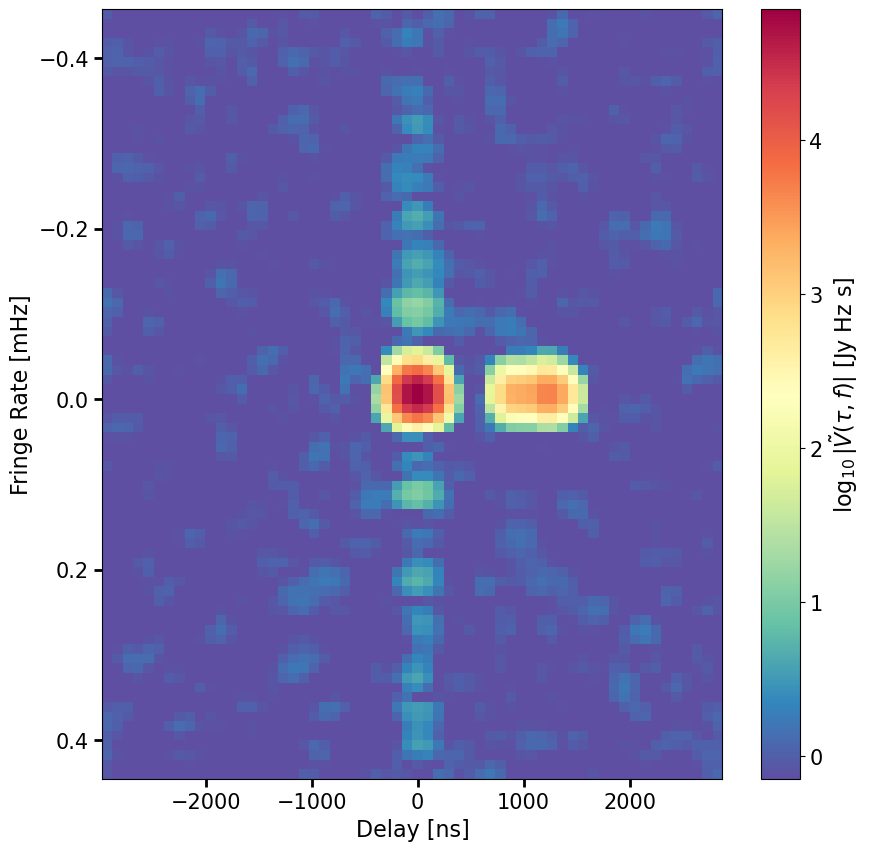

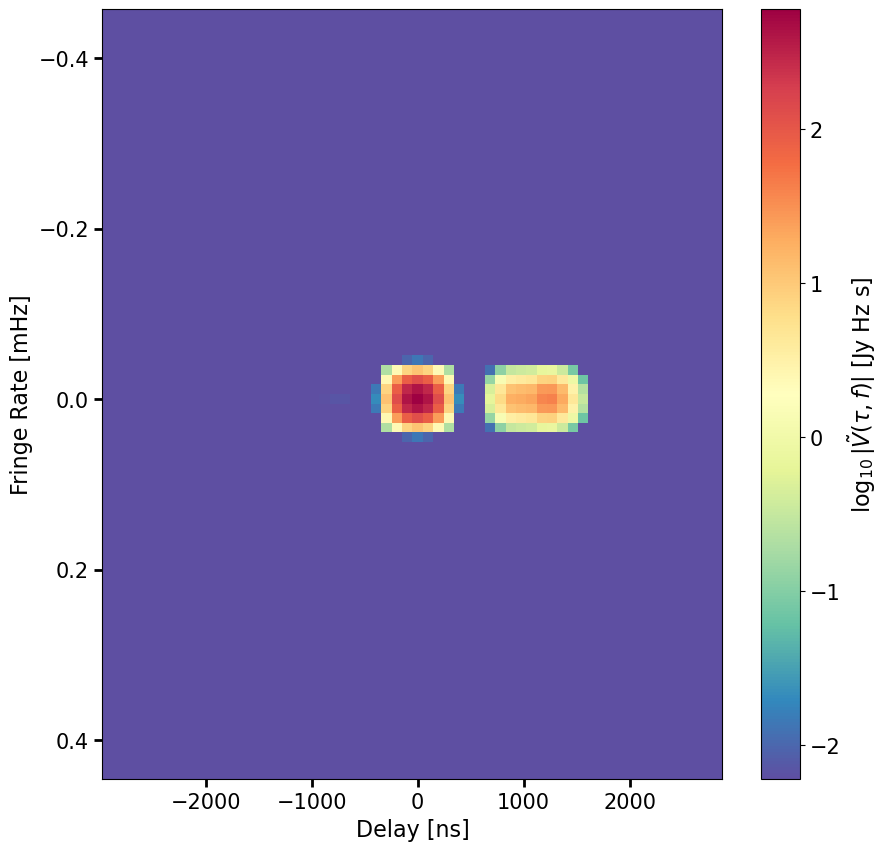

In [9]:
true_total_dlfr=plot_waterfalls(data_true, freqs*1e6, lsts, windows='blackman-harris', fig=None,ax=None, mode='log', 
                vmin=None,vmax=None,cmap='Spectral_r', dynamic_range=5, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)[1]

sys_subtraction=(1+(sys_modes_operator@ (sys_amps_true))).reshape((Ntimes,Nfreqs),order='F')

sys_true_dlfr=plot_waterfalls(sys_subtraction, freqs*1e6, lsts, windows='blackman-harris', fig=None,ax=None, mode='log', 
                vmin=None,vmax=None,cmap='Spectral_r', dynamic_range=5, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)[1]

data_filtered_dlfr = true_total_dlfr - sys_true_dlfr


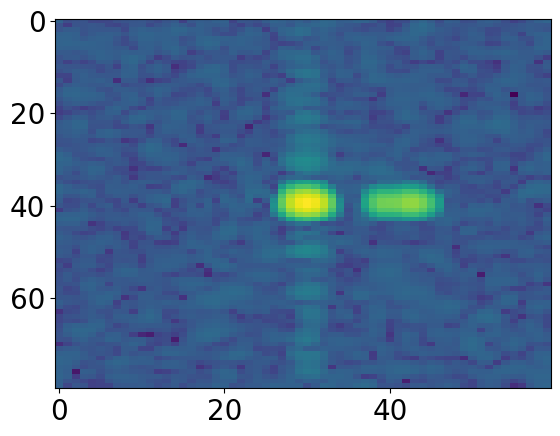

In [10]:
waterfall(data_filtered_dlfr)

In [11]:
eps=1e-12
data_unshifted = np.fft.ifftshift(data_filtered_dlfr,axes=1)
temp = np.fft.ifft(data_unshifted,axis=1)
freq_window = gen_window('blackman-harris', freqs.size)[None,:]
data_recon = temp / np.where(freq_window != 0, freq_window, eps)

data_unshifted = np.fft.ifftshift(data_recon,axes=0)
temp = np.fft.ifft(data_unshifted,axis=0)
time_window = gen_window('blackman-harris', lsts.size)[:,None]
data_recon = temp / np.where(time_window != 0, time_window, eps)

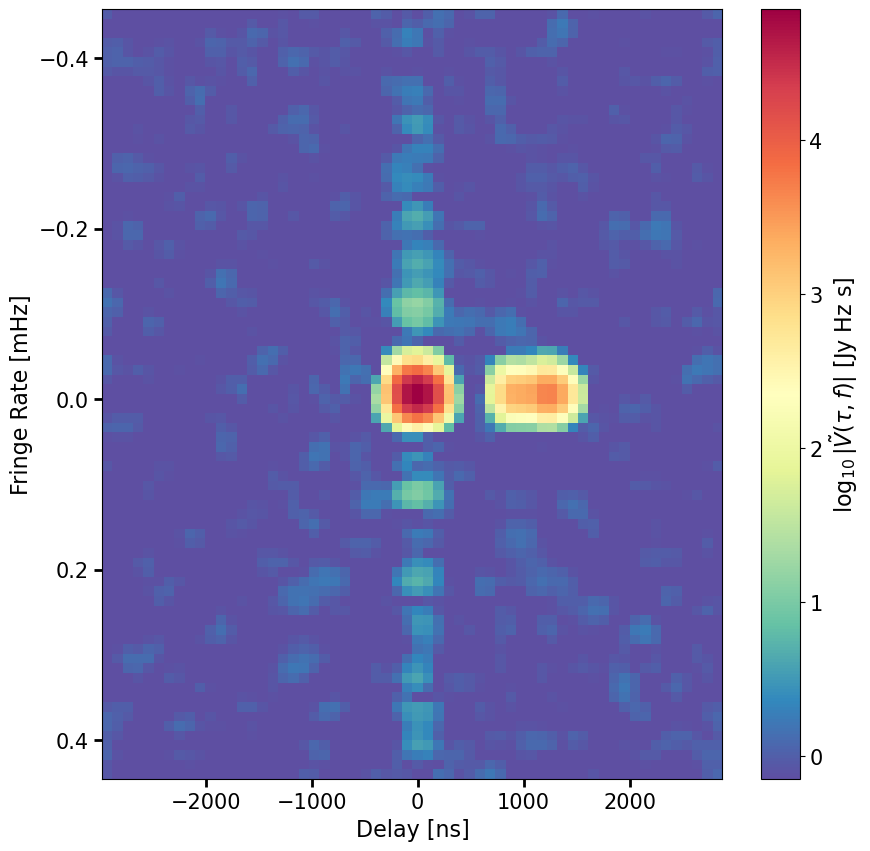

In [12]:
data_filtered_dlfr = plot_waterfalls(data_true-sys_subtraction, freqs*1e6, lsts, windows='blackman-harris', fig=None,ax=None, mode='log', 
                vmin=None,vmax=None,cmap='Spectral_r', dynamic_range=5, limit_drng='all', colorbar_flag=True,
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)[1]

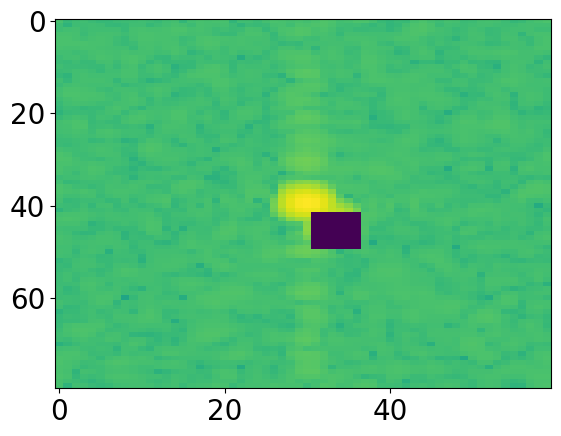

In [59]:
waterfall(true_total_dlfr[44:53,37:45])

masked_dlfr=true_total_dlfr.copy()
masked_dlfr[42:50,31:37]=1e-12

waterfall(masked_dlfr)

# eps=1e-12
# data_unshifted = np.fft.ifftshift(masked_dlfr,axes=1)
# temp = np.fft.ifft(data_unshifted,axis=1)
# freq_window = gen_window('blackman-harris', freqs.size)[None,:]
# data_recon = temp / np.where(freq_window != 0, freq_window, eps)

# data_unshifted = np.fft.ifftshift(data_recon,axes=0)
# temp = np.fft.ifft(data_unshifted,axis=0)
# time_window = gen_window('blackman-harris', lsts.size)[:,None]
# data_recon = temp / np.where(time_window != 0, time_window, eps)

# plt.imshow(data_recon.real)
# plt.colorbar()

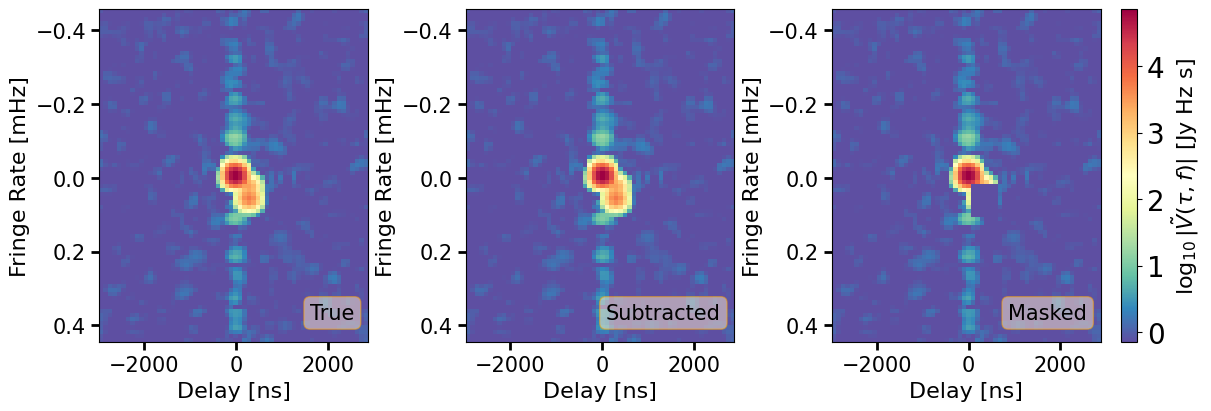

In [64]:
fig,axs = plt.subplots(1,3,layout="constrained",figsize=(12,4))
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
i=0
data_arr=[data_true,true_total_dlfr-sys_true_dlfr,masked_dlfr]
fig_labels = ['True','Subtracted','Masked']
plot_op=plot_waterfalls(data_true, freqs*1e6, lsts, windows='blackman-harris', fig=fig,ax=axs[0], mode='log', 
                vmin=None,vmax=None,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',colorbar_flag=False,
                freq_window_kwargs=None, time_window_kwargs=None)
axs[0].text(0.95,0.07,fig_labels[i],fontsize=15, bbox=bbox,
            transform=axs[0].transAxes, horizontalalignment='right')


for i in range(2):
    _=plot_waterfalls_from_dlfr(data_arr[i+1], freqs*1e6, lsts, fig=fig,ax=axs[i+1], mode='log', 
                vmin=None,vmax=None,cmap='Spectral_r', dynamic_range=5, limit_drng='all', colorbar_flag=False,
                baseline=None, horizon_color='magenta')
    axs[i+1].text(0.95,0.07,fig_labels[i+1],fontsize=15, bbox=bbox,
            transform=axs[i+1].transAxes, horizontalalignment='right')
    i=i+1

_=fig.colorbar(plot_op[0], ax=axs, orientation='vertical', fraction=0.9, pad=0.02)
vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
_.set_label(vis_label,c='black',fontsize=16)
plt.savefig(result_dir+'/'+'method_comparison.pdf',bbox_inches='tight',dpi=300)

# Plotting data

In [23]:
uvd=UVData()
uvd.read('/Users/user/Documents/Codes/hydra_sys_project1/hydra-pspec-systematic-multiplicative/test_data/vis-eor.uvh5')
antpairpols=uvd.get_antpairpols()
vis_eor=uvd.get_data(antpairpols[0], force_copy=True) #EoR test
freqs=uvd.freq_array
freqs_corr=freqs.reshape(freqs.shape[1],) #[0]
lst_corr=np.unique(uvd.lst_array)

uvd=UVData()
uvd.read('/Users/user/Documents/Codes/hydra_sys_project1/hydra-pspec-systematic-multiplicative/test_data/vis-ptsrc-gsm.uvh5')
antpairpols=uvd.get_antpairpols()
vis_fg=uvd.get_data(antpairpols[0], force_copy=True) #EoR test

uvd=UVData()
uvd.read('/Users/user/Documents/Codes/hydra_sys_project1/hydra-pspec-systematic-multiplicative/hera_val/vis_corrupted_test.uvh5')
antpairpols=uvd.get_antpairpols()
vis_corr=uvd.get_data(['xx'], force_copy=True) #EoR test

noise=np.load('/Users/user/Documents/Codes/hydra_sys_project1/hydra-pspec-systematic-multiplicative/test_data/noise.npy')

Telescope Hex37-14.6m is not in known_telescopes.
Telescope Hex37-14.6m is not in known_telescopes.
Telescope Hex37-14.6m is not in known_telescopes.


In [26]:
vis_corr.shape

(203, 120)

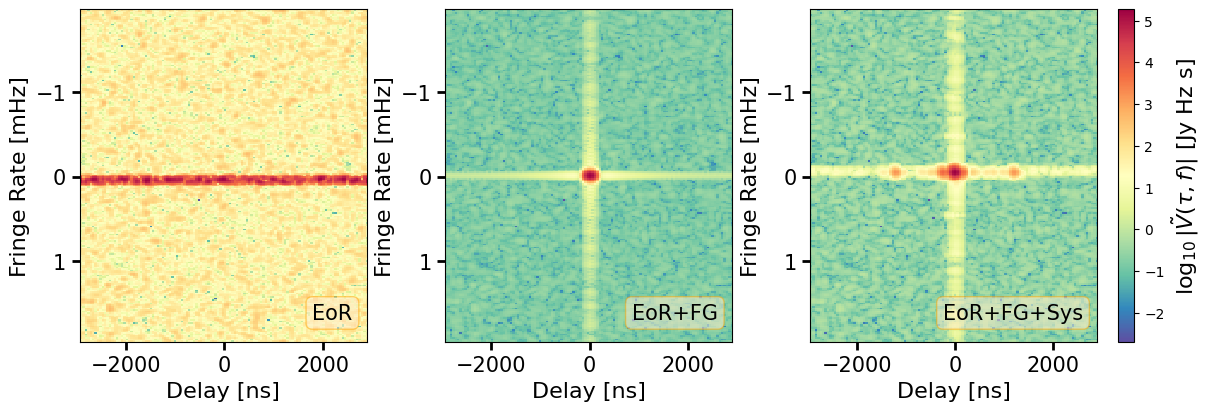

In [88]:
fig,axs = plt.subplots(1,3,layout="constrained",figsize=(12,4))
bbox = dict(boxstyle='round', fc='blanchedalmond', ec='orange', alpha=0.5)
        
eor_dlfr=plot_waterfalls(vis_eor+noise, freqs_corr, lst_corr, windows='blackman-harris', fig=fig,ax=axs[0], mode='log', 
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[0].text(0.95,0.07,'EoR',fontsize=15, bbox=bbox,
            transform=axs[0].transAxes, horizontalalignment='right')
fg_dlfr = plot_waterfalls(vis_fg+noise, freqs_corr, lst_corr, windows='blackman-harris', mode='log', fig=fig,ax=axs[1],
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[1].text(0.95,0.07,'EoR+FG',fontsize=15, bbox=bbox,
            transform=axs[1].transAxes, horizontalalignment='right')
corr_dlfr=plot_waterfalls(vis_corr+noise, freqs_corr, lst_corr, windows='blackman-harris', mode='log', fig=fig,ax=axs[2],
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[2].text(0.95,0.07,'EoR+FG+Sys',fontsize=15, bbox=bbox,
            transform=axs[2].transAxes, horizontalalignment='right')
_=fig.colorbar(corr_dlfr[0], ax=axs, orientation='vertical', fraction=0.9, pad=0.02)
vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
_.set_label(vis_label,c='black',fontsize=16)
# _.ax.tick_params(axis='y',which='both', color='black', labelcolor='black',labelsize=15)
plt.savefig(result_dir+'/'+'data_in_dlfr_space.pdf',bbox_inches='tight',dpi=300)

In [14]:
eor_dlfr

(<matplotlib.image.AxesImage at 0x320b88860>,
 array([[ 2.45313843e-05+3.17743725e-05j, -2.51757343e-05-8.70872565e-06j,
          3.33258080e-05-1.14472645e-05j, ...,
          1.16583640e-04-6.00979976e-05j, -4.63175608e-05+1.08938198e-04j,
         -2.73220512e-05-7.79700276e-05j],
        [-1.23115704e-06-1.35320911e-05j, -8.55442017e-06+1.74316951e-05j,
          8.77718342e-06-2.28993003e-05j, ...,
         -4.85876961e-05+6.08985238e-05j,  1.87470031e-05-6.58451628e-05j,
          2.01691104e-05+3.38694016e-05j],
        [-2.24752148e-05+3.90247468e-06j,  2.35375511e-05-2.16276893e-05j,
         -2.41002440e-05+4.40875677e-05j, ...,
         -8.74030447e-06-4.34587405e-05j,  6.54079277e-06+2.03152780e-05j,
         -3.38805440e-07-1.34026324e-07j],
        ...,
        [ 4.45592915e-05+3.19918793e-06j, -6.76600620e-05+8.47718261e-05j,
         -3.45116300e-05-1.41939300e-04j, ...,
         -2.79801898e-05+7.12786077e-05j, -5.68466122e-06-6.55465180e-05j,
          7.46923785e-06

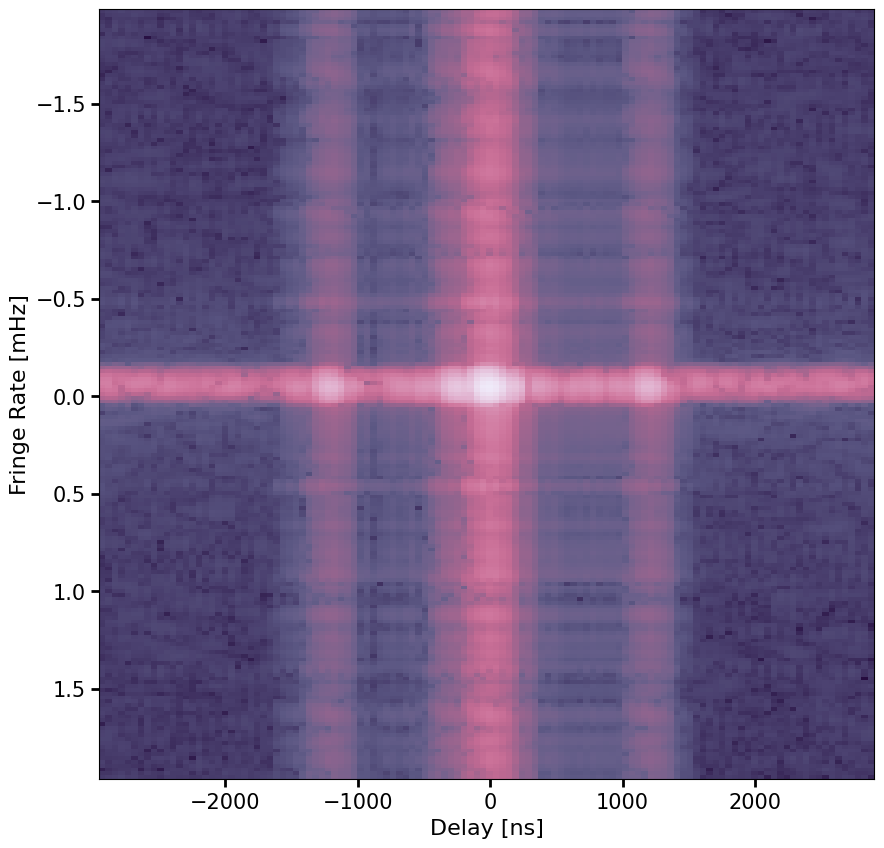

In [15]:
corr_dlfr=plot_waterfalls(vis_corr, freqs_corr, lst_corr, windows='blackman-harris', mode='log', 
                    cmap=cmc.acton, dynamic_range=5, limit_drng='all',
                    baseline=None, horizon_color='magenta',
                    freq_window_kwargs=None, time_window_kwargs=None)

plt.savefig(result_dir+'Corr_viss_dlfr_space.png',bbox_inches='tight',dpi=300)

In [16]:
corr_dlfr[0]

In [17]:
clean_dlfr=plot_waterfalls(total_data_true.T, freqs*1e6, lsts, windows='blackman-harris', mode='log', 
                    cmap=cmc.acton, dynamic_range=5, limit_drng='all',
                    baseline=None, horizon_color='magenta',
                    freq_window_kwargs=None, time_window_kwargs=None)
# plt.savefig('/Users/user/Documents/Codes/hydra_sys_project1/hydra-pspec-systematic-multiplicative/outputs/Sky data.png', transparent=True,
            # bbox_inches='tight',dpi=300)
# plt.title("Simulated visibilities in Delay-Fringe rate space",fontsize=16)
plt.savefig(result_dir+run_version+'/plots/'+'data_in_dlfr_space.png',bbox_inches='tight',dpi=300)

ValueError: operands could not be broadcast together with shapes (60,60) (1,120) 

# Plotting results

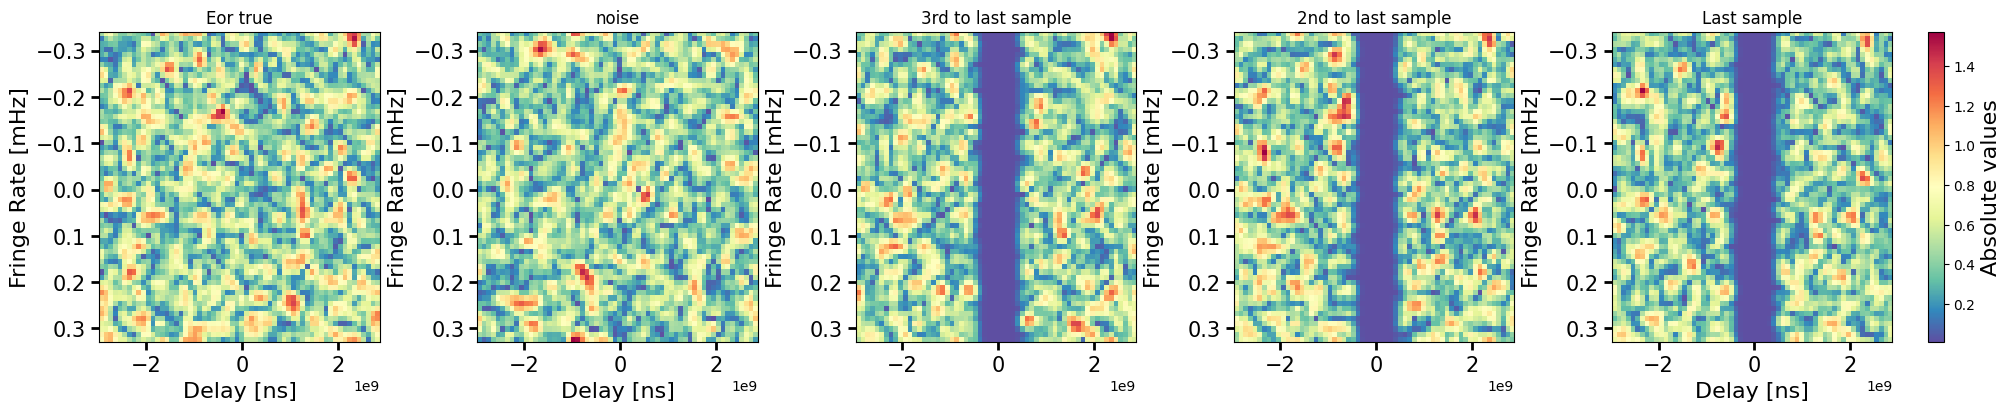

In [75]:
fig,axs = plt.subplots(1,5,layout="constrained",figsize=(20,4))
# vmax = np.log10(np.abs(eor_true)).max()
# vmin = vmax - 5
vmin=None
vmax=None
eor_dlfr=plot_waterfalls(eor_true, freqs, lsts, windows='blackman-harris', fig=fig,ax=axs[0], mode='abs', 
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[0].set_title("Eor true")

noise_dlfr=plot_waterfalls(n, freqs, lsts, windows='blackman-harris', fig=fig,ax=axs[1], mode='abs', 
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[1].set_title('noise')
signal_amps_0=plot_waterfalls(signal_amps[-1,:,:], freqs, lsts, windows='blackman-harris', fig=fig,ax=axs[2], xlabel='',mode='abs', 
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[2].set_title("3rd to last sample")

signal_amps_1 = plot_waterfalls(signal_amps[-2,:,:], freqs, lsts, windows='blackman-harris', mode='abs', xlabel='',fig=fig,ax=axs[3],
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[3].set_title("2nd to last sample")

signal_amps_2=plot_waterfalls(signal_amps[-3,:,:], freqs, lsts, windows='blackman-harris', mode='abs', fig=fig,ax=axs[4],
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[4].set_title("Last sample")

_=fig.colorbar(eor_dlfr[0], ax=axs, orientation='vertical', fraction=0.9, pad=0.02)
vis_label = r"Absolute values"
_.set_label(vis_label,c='black',fontsize=16)
# _.ax.tick_params(axis='y',which='both', color='black', labelcolor='black',labelsize=15)

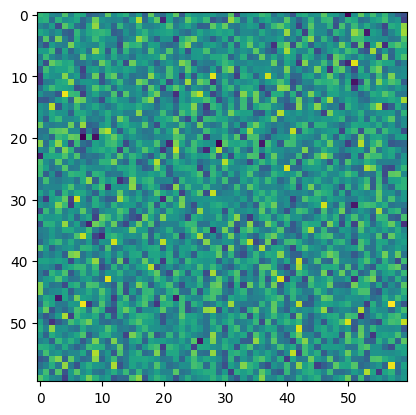

In [48]:
fig,axs = plt.subplots(1,4,layout="constrained",figsize=(16,4))
vmax = np.log10(np.abs(eor_true)).max()
vmin = vmax - 5
eor_dlfr=plot_waterfalls(eor_true, freqs, lsts, windows='blackman-harris', fig=fig,ax=axs[0], mode='log', 
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[0].set_title("Eor true")
signal_amps_0=plot_waterfalls(signal_amps[-1,:,:].T, freqs, lsts, windows='blackman-harris', fig=fig,ax=axs[1], xlabel='',mode='log', 
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[1].set_title("3rd to last sample")

signal_amps_1 = plot_waterfalls(signal_amps[-2,:,:].T, freqs, lsts, windows='blackman-harris', mode='log', xlabel='',fig=fig,ax=axs[2],
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[2].set_title("2nd to last sample")

signal_amps_2=plot_waterfalls(signal_amps[-3,:,:].T, freqs, lsts, windows='blackman-harris', mode='log', fig=fig,ax=axs[3],
                vmin=vmin,vmax=vmax,cmap='Spectral_r', dynamic_range=5, limit_drng='all',
                baseline=None, horizon_color='magenta',
                freq_window_kwargs=None, time_window_kwargs=None)
axs[3].set_title("Last sample")

_=fig.colorbar(eor_dlfr[0], ax=axs, orientation='vertical', fraction=0.9, pad=0.02)
vis_label = r"$\log_{10}|\tilde{V}(\tau, f)|$ [Jy Hz s]"
_.set_label(vis_label,c='black',fontsize=16)
# _.ax.tick_params(axis='y',which='both', color='black', labelcolor='black',labelsize=15)

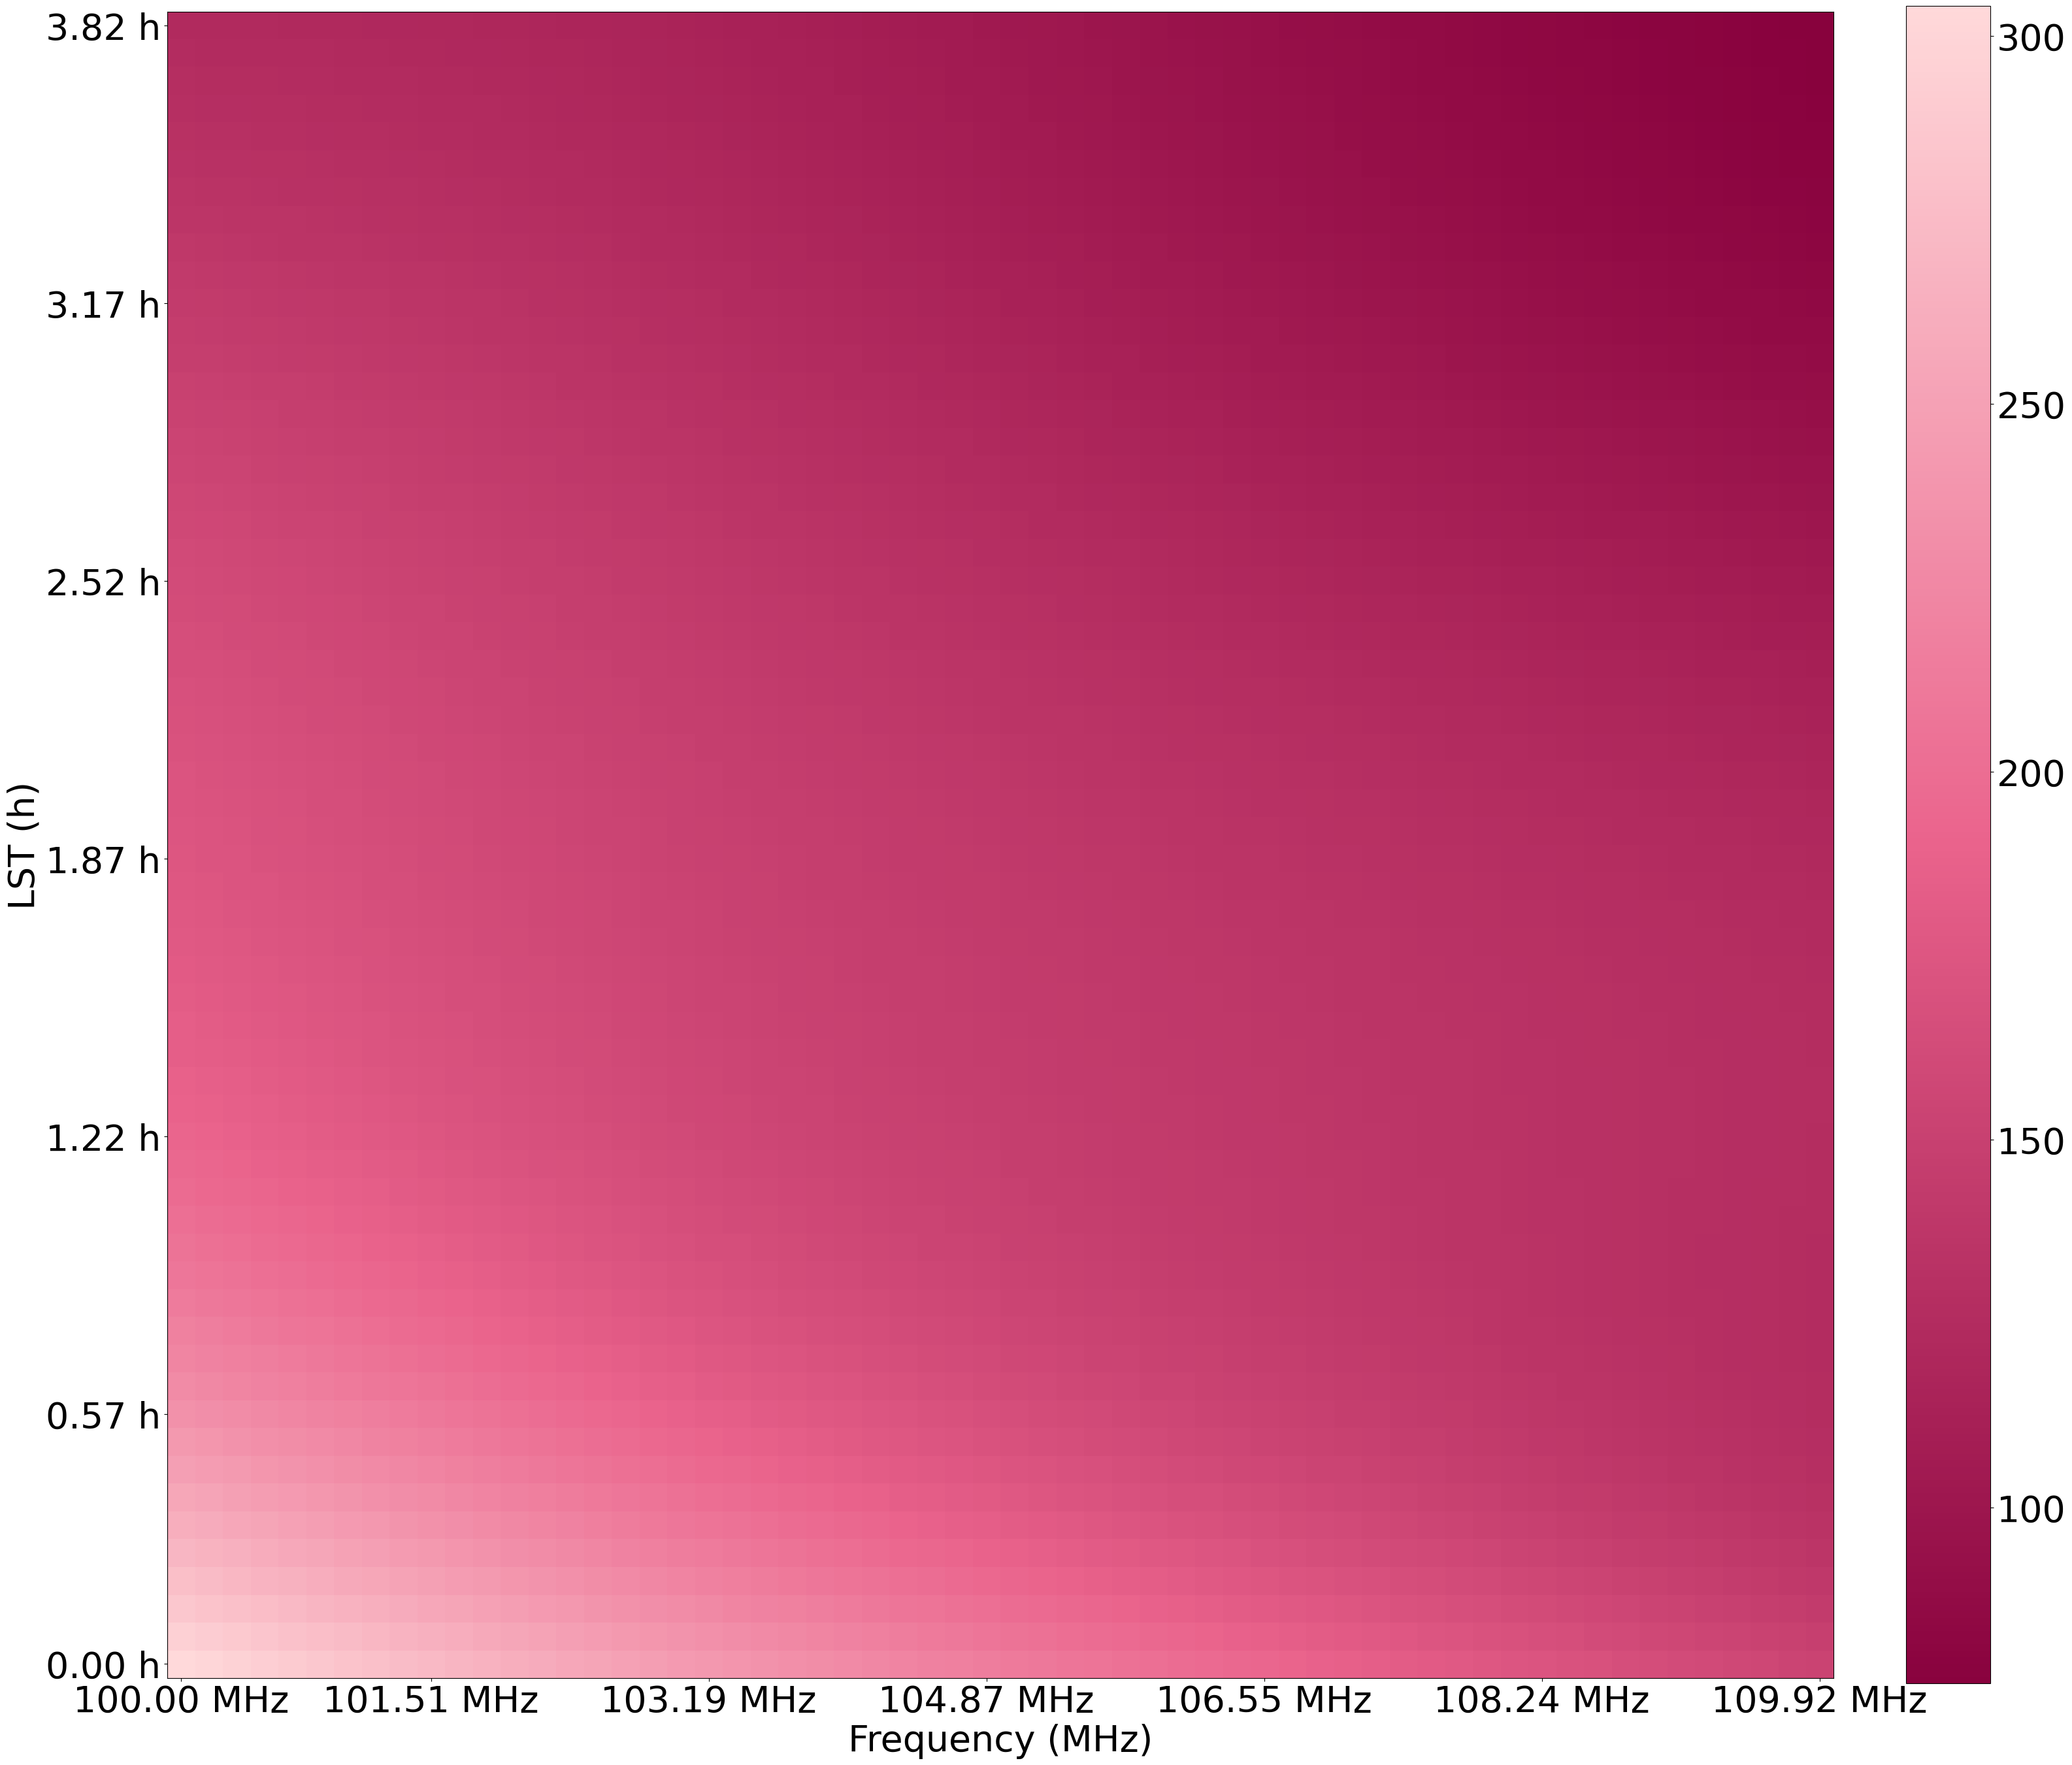

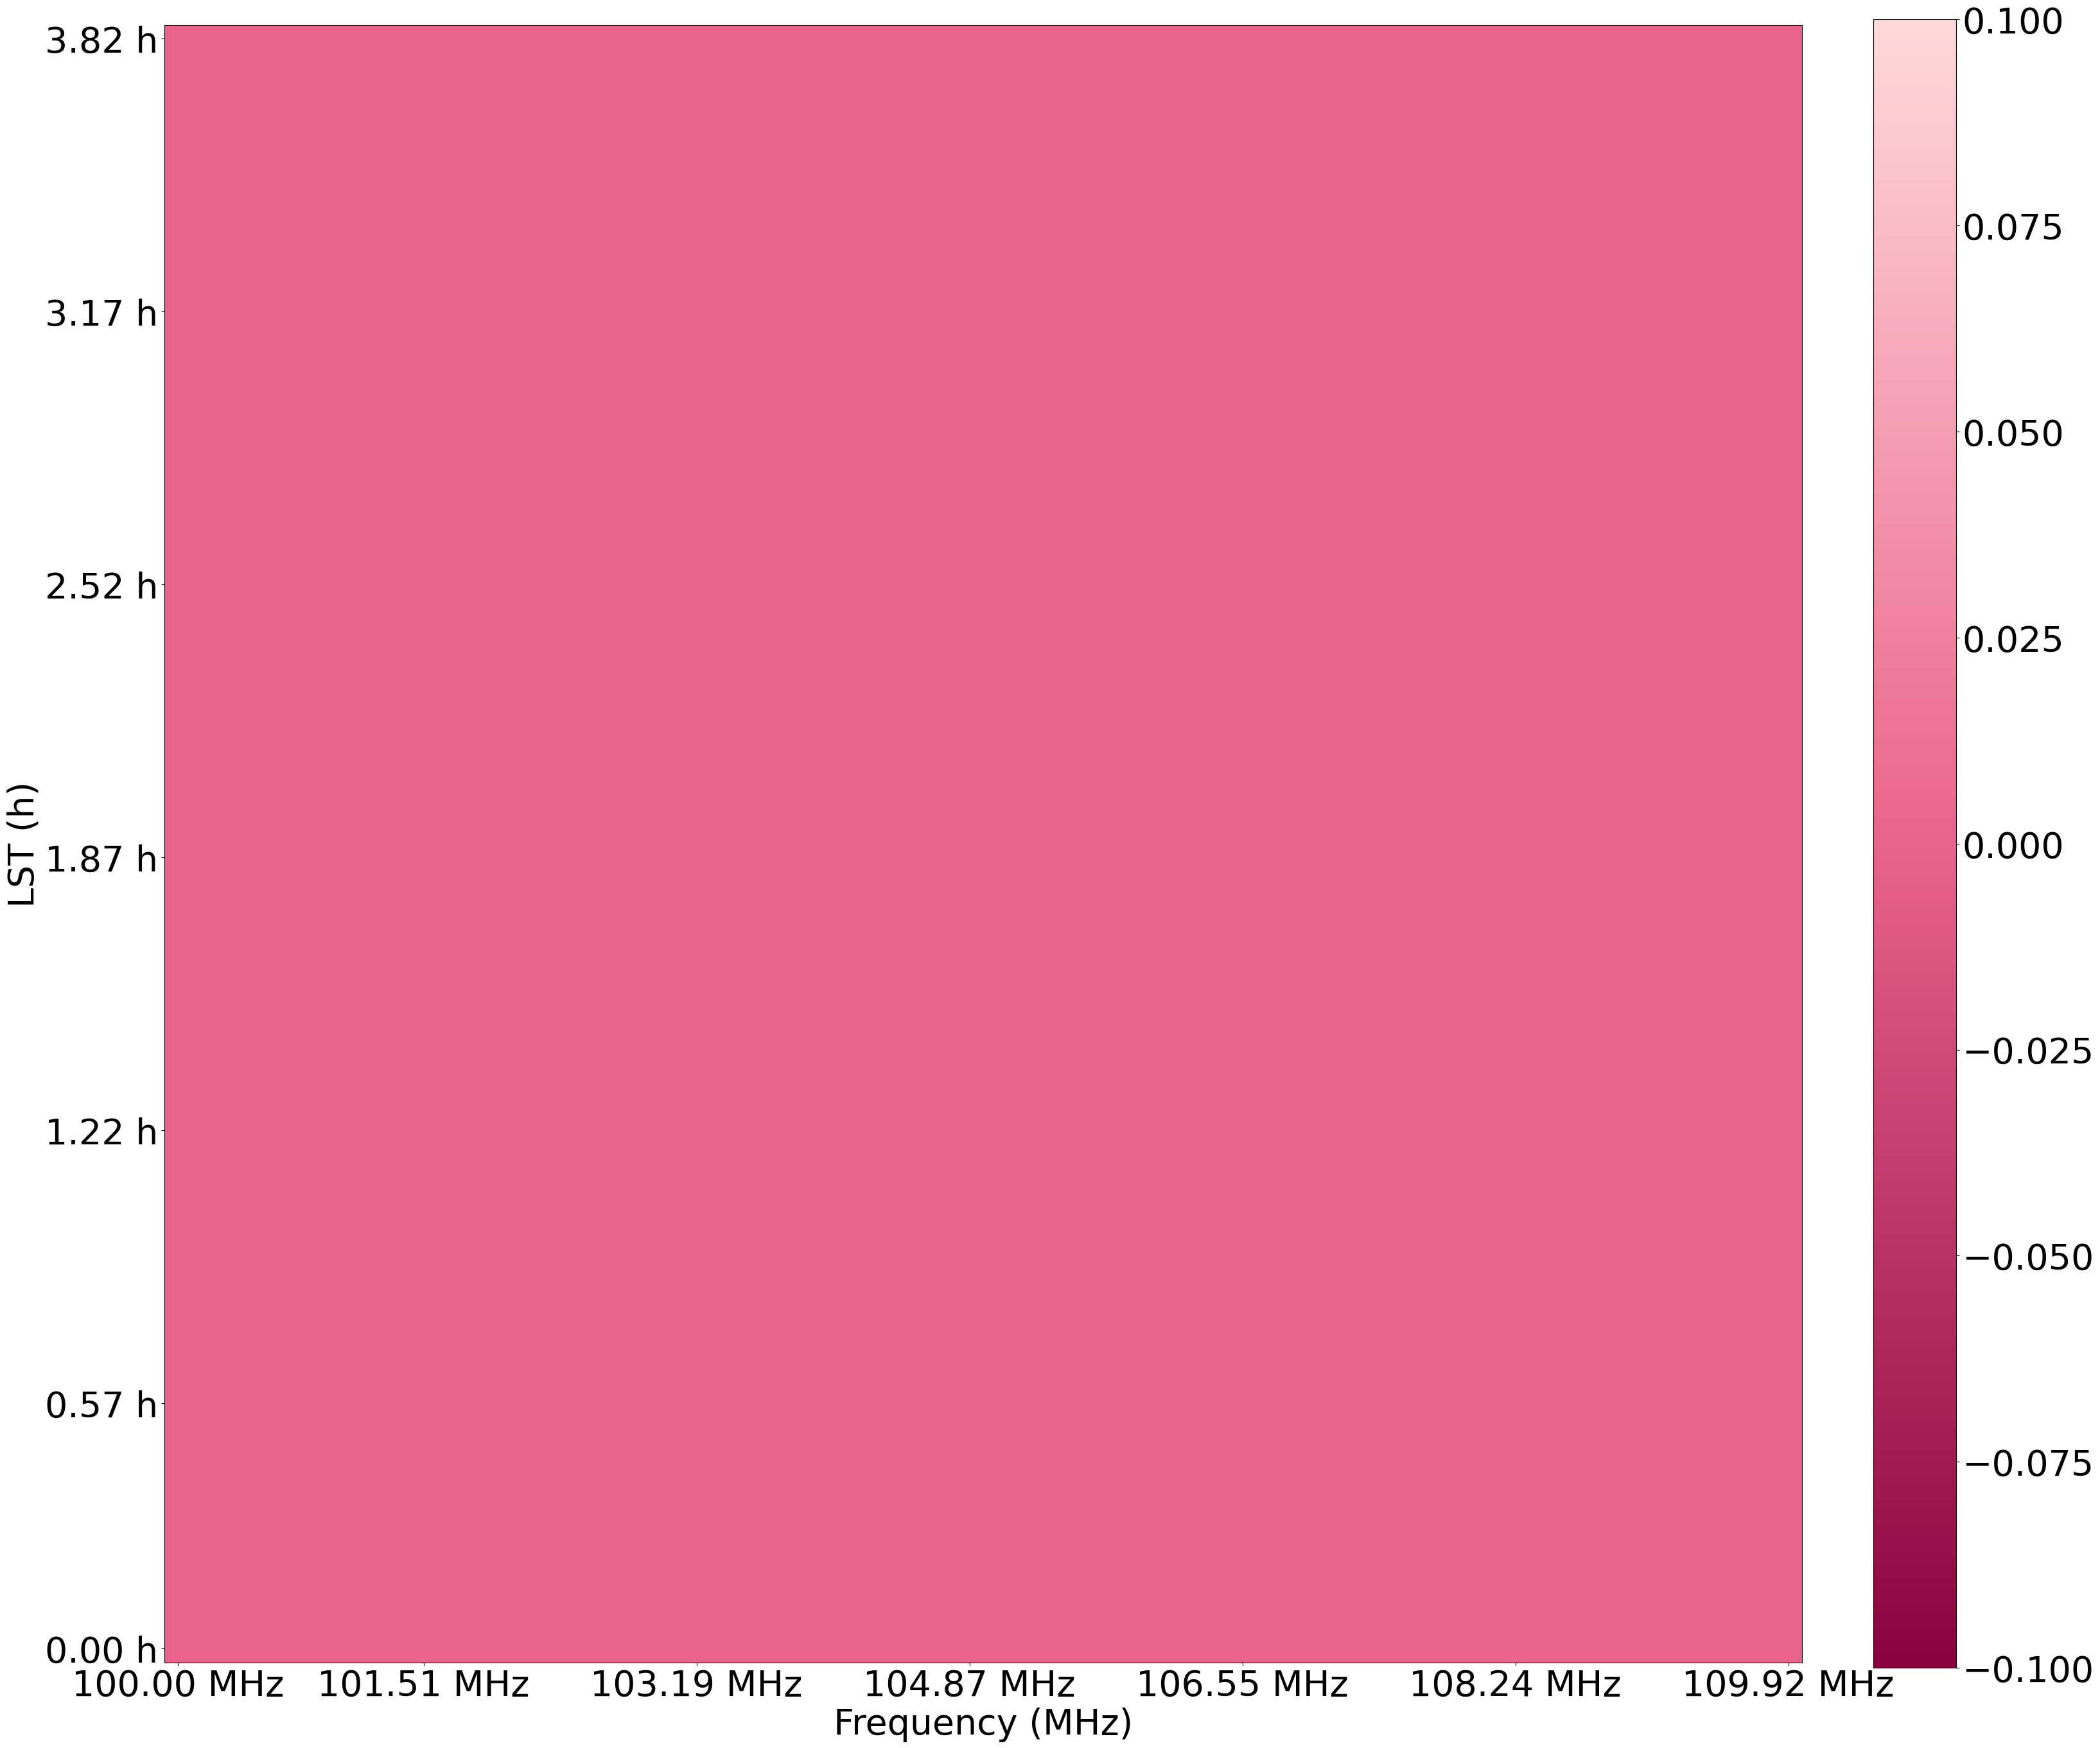

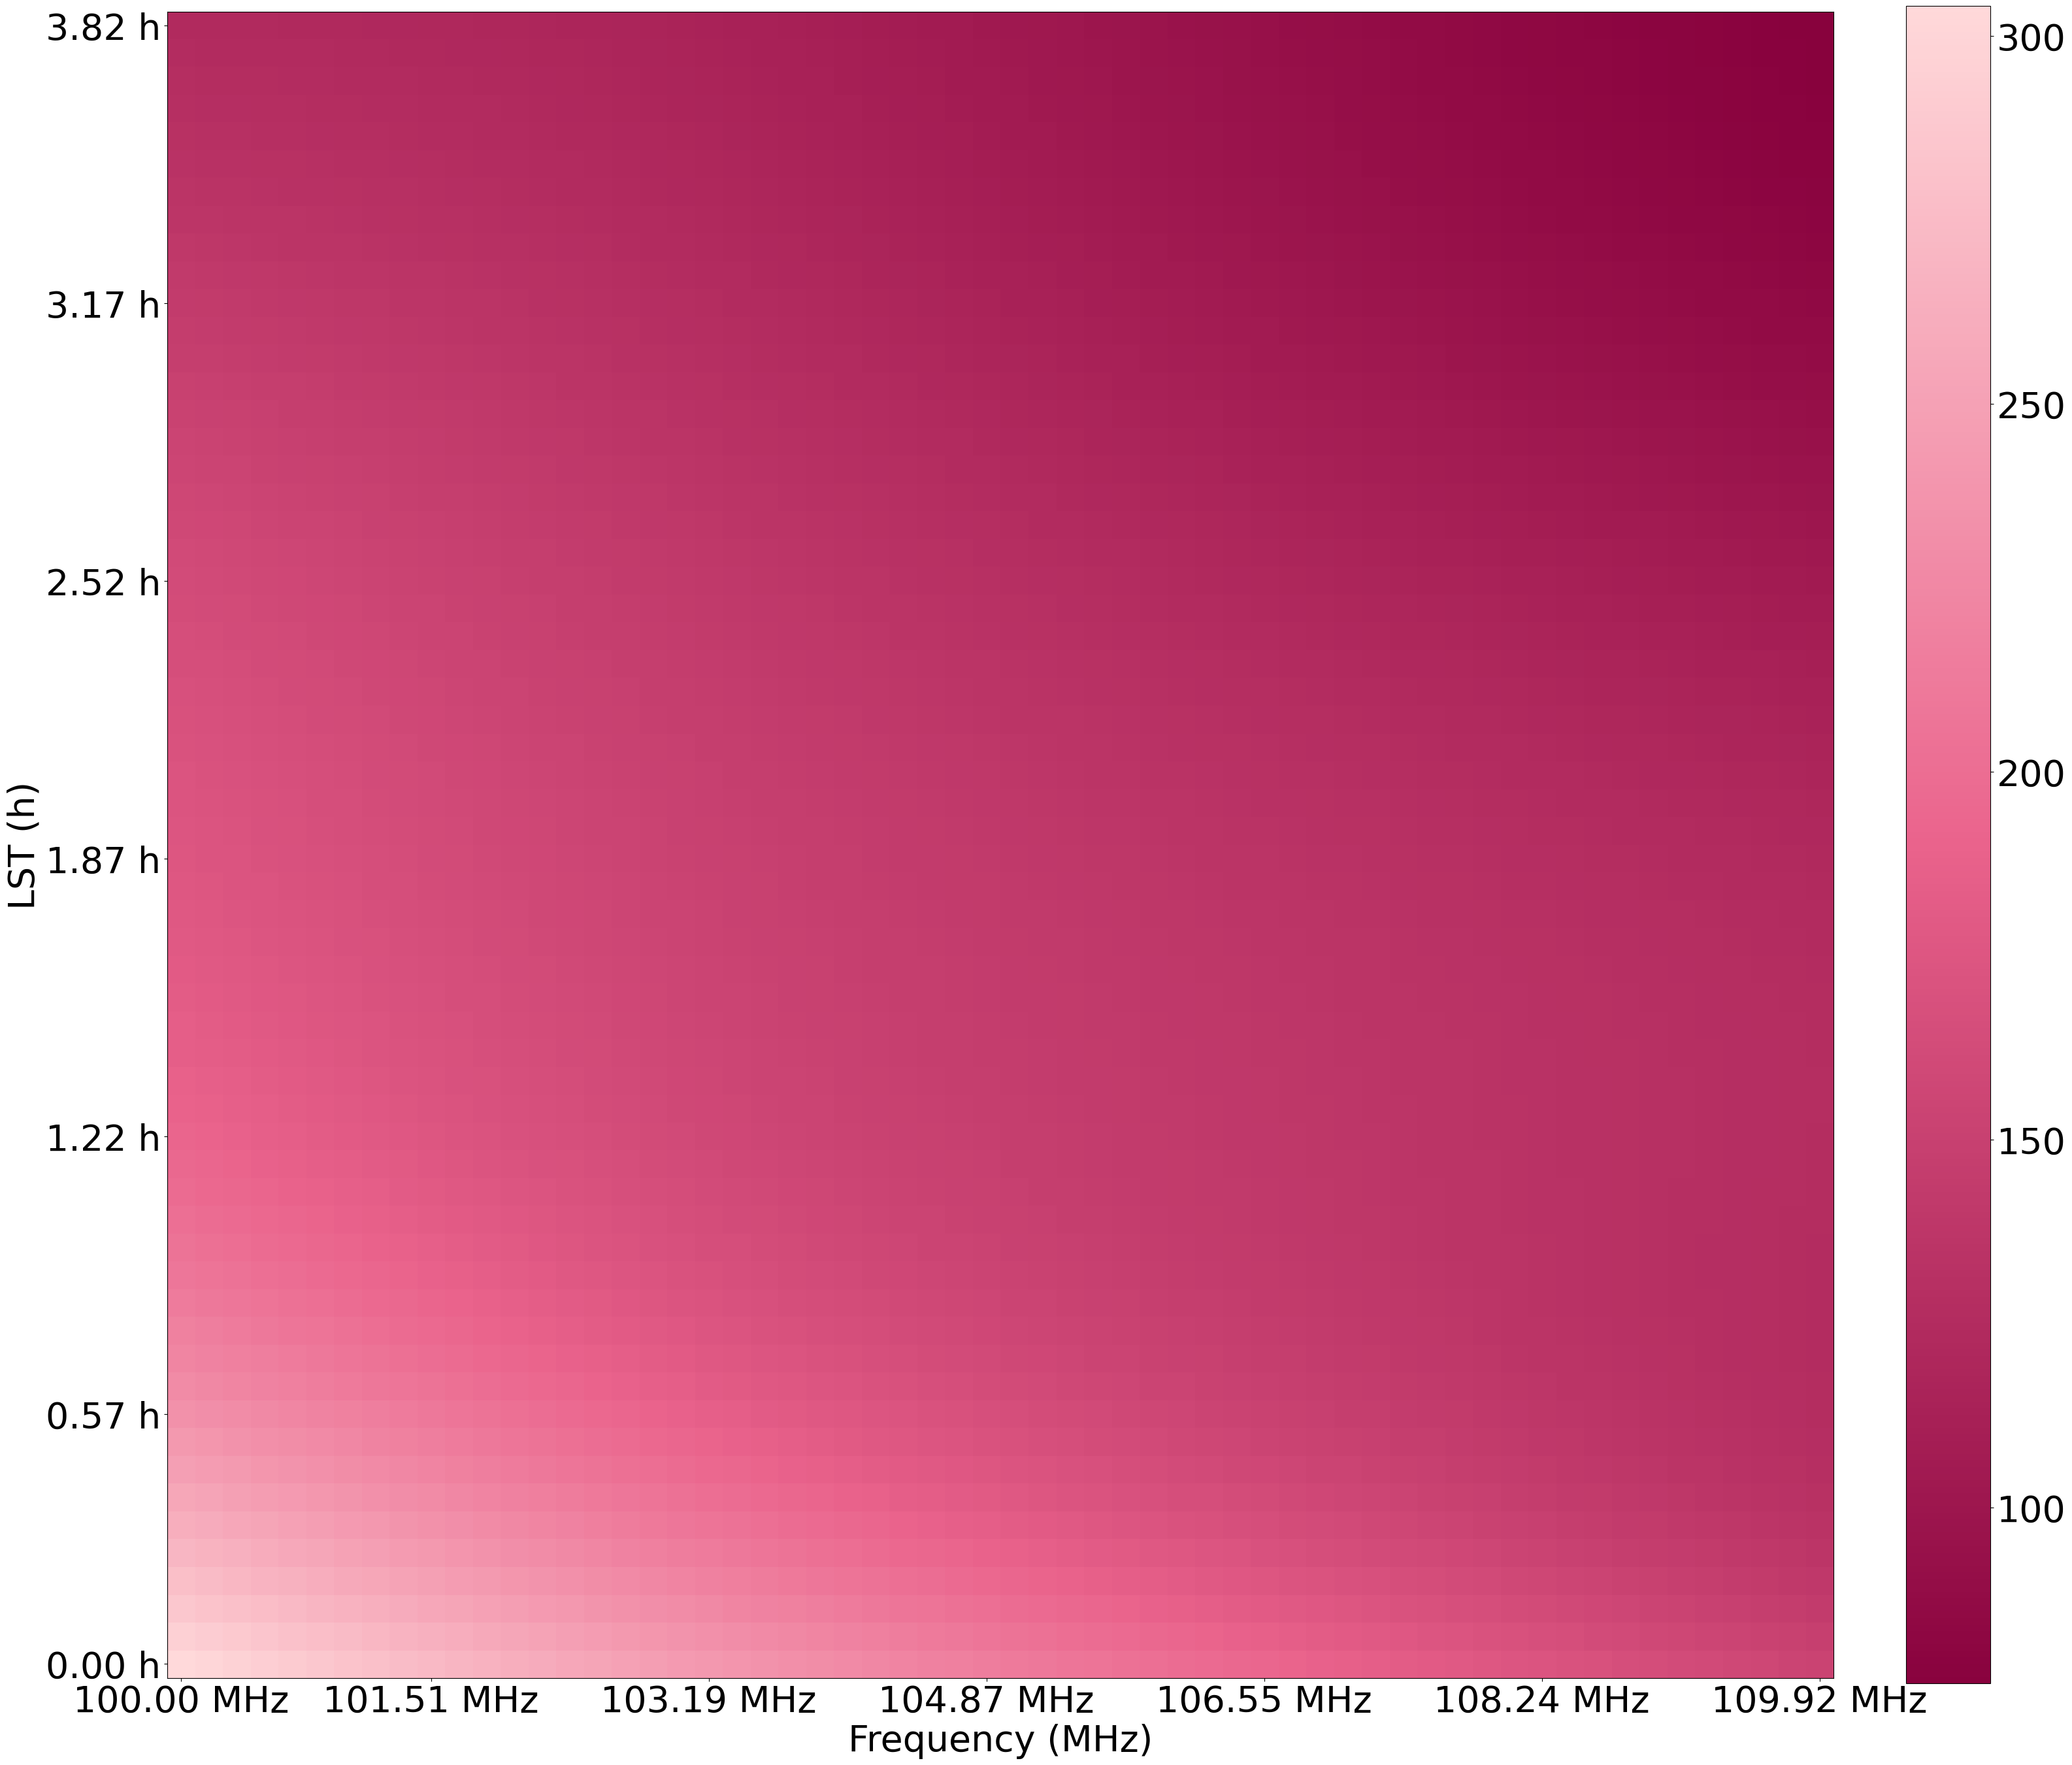

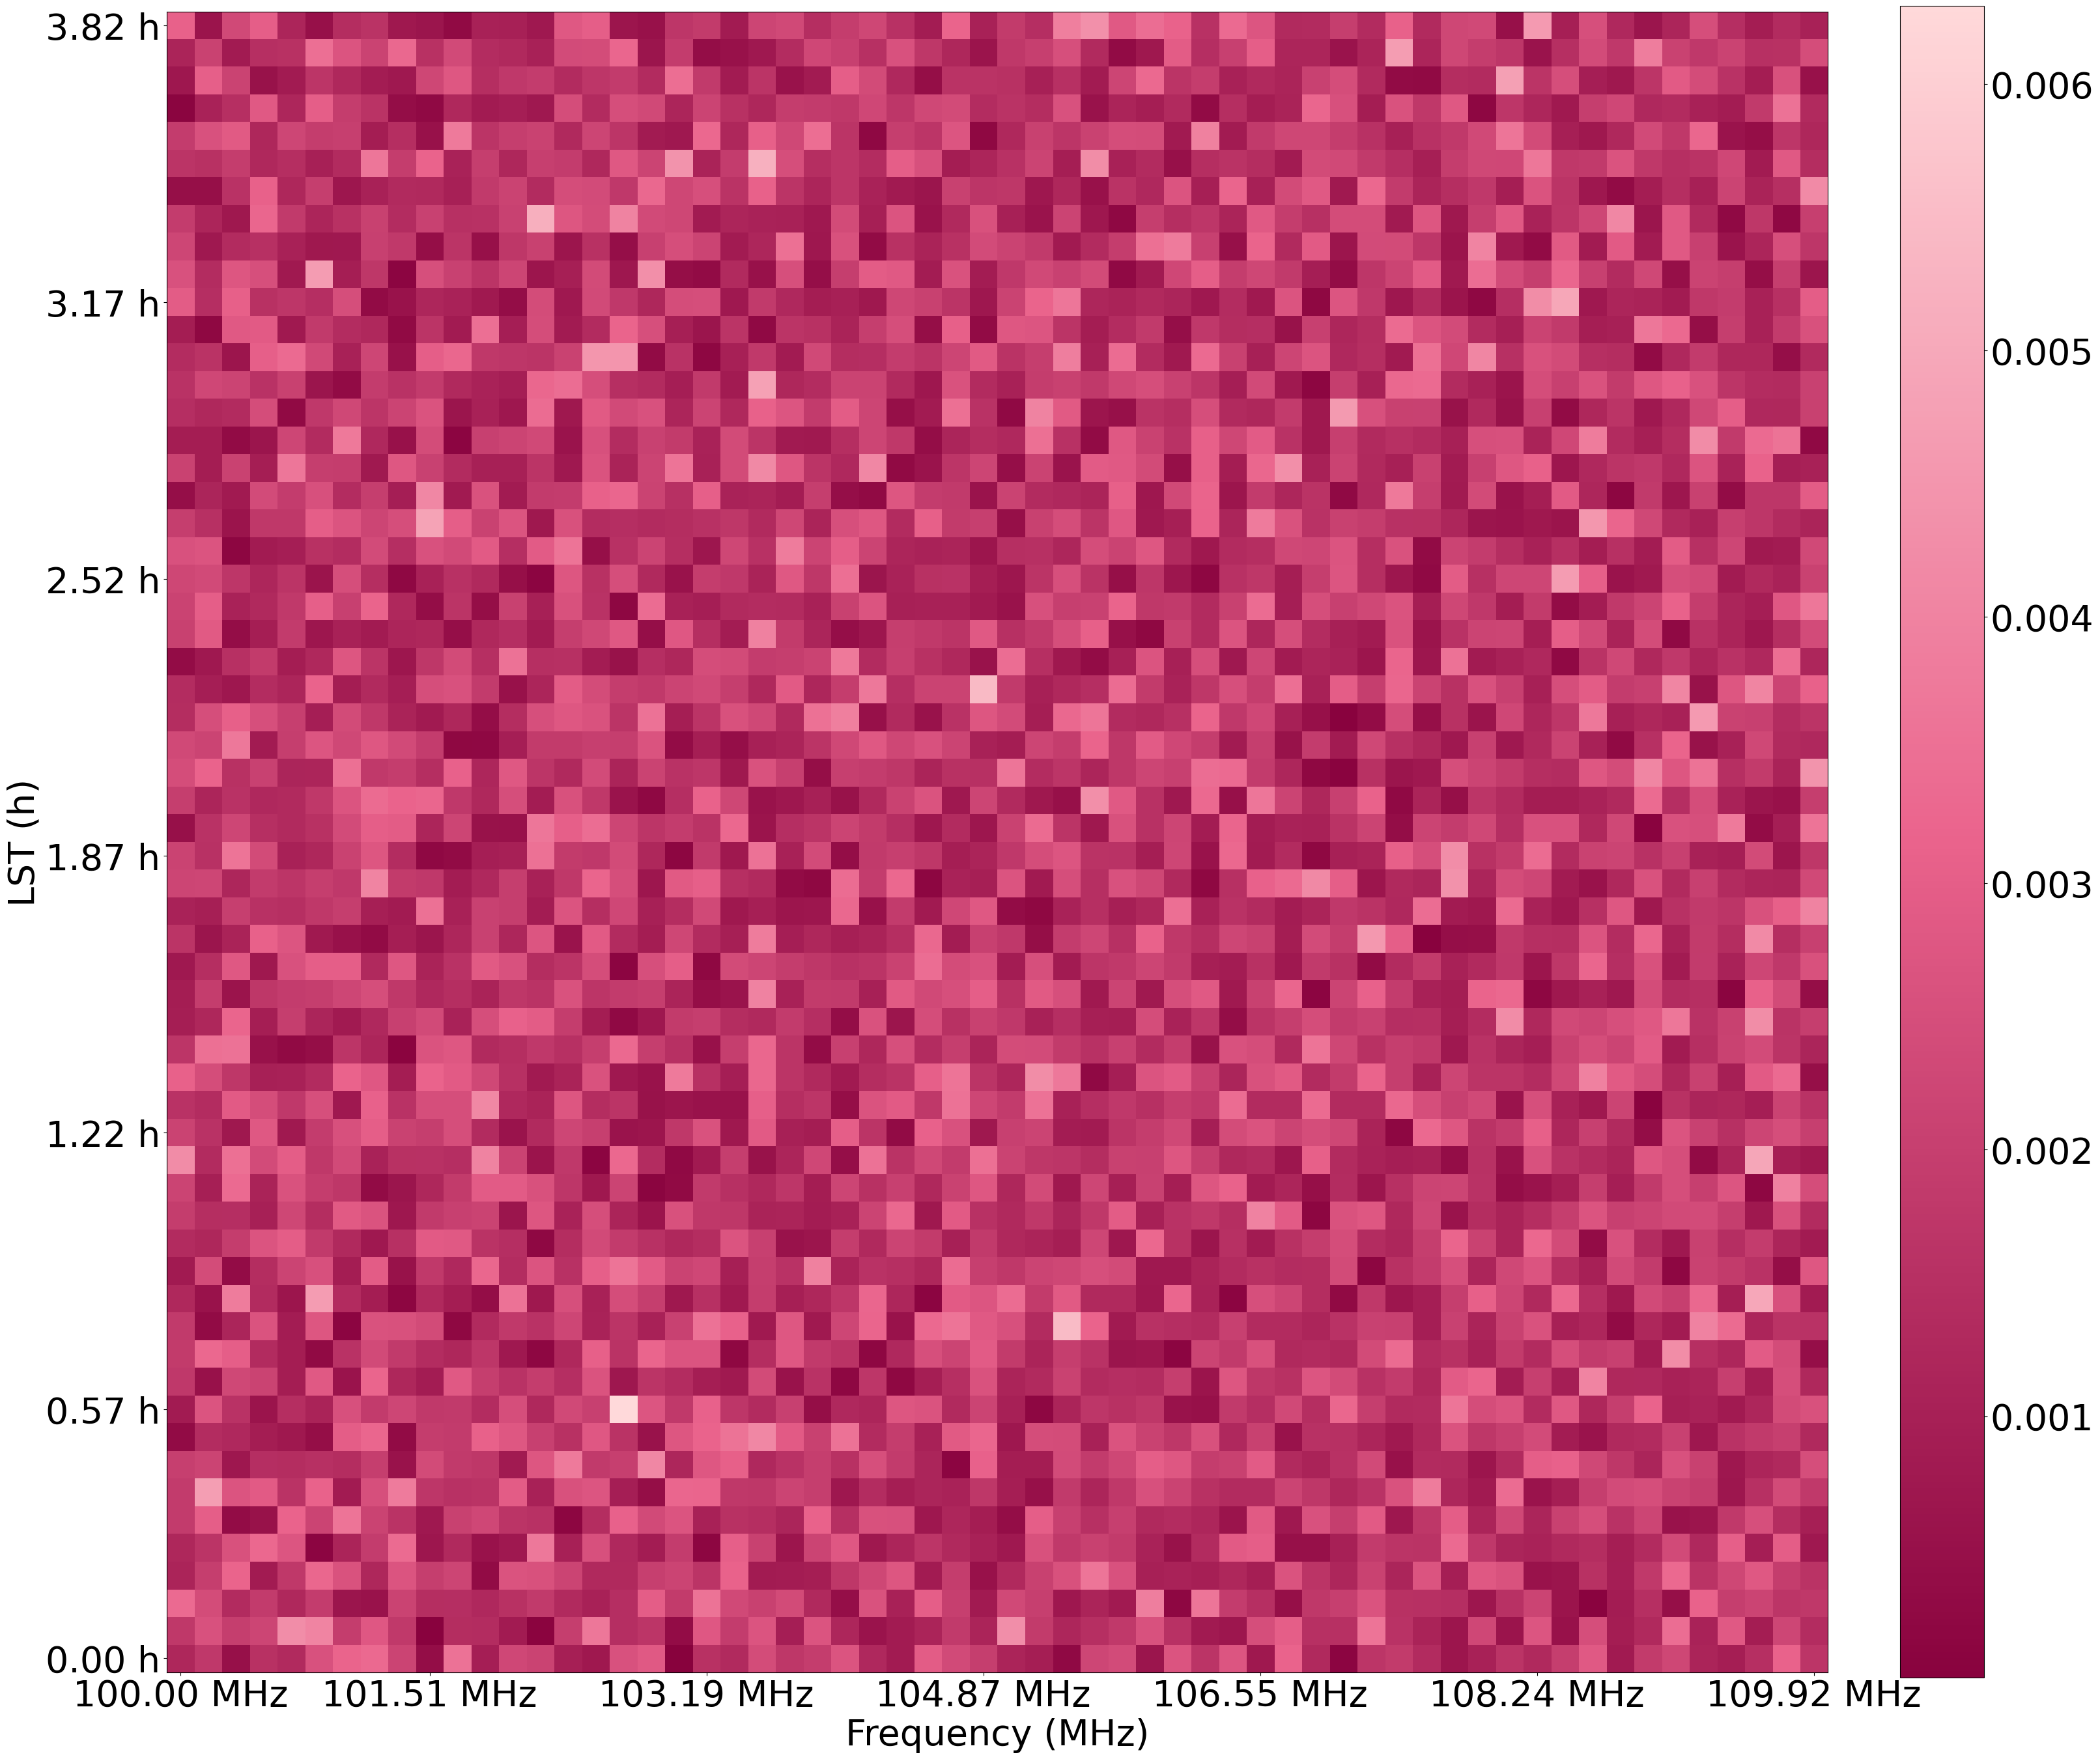

In [ ]:
import matplotlib as mpl

mpl.rcParams['font.size']=40

data_list=[np.abs(data_true),np.abs(model),np.abs(model-data_true),np.abs(n.T)]
names=['true_sky_model','sampled_sky_model','residuals','noise']
for i in range(0,4):
    fig,ax = plt.subplots(1,1,figsize=(36,36))

    im=ax.imshow(data_list[i],cmap=paper_cmap, origin='lower', norm='linear')
    plt.colorbar(im, ax=ax,fraction=0.046, pad=0.04)

    ax.set_xticks(xticklocs)
    ax.set_xticklabels(xticklabels)

    ax.set_yticks(yticklocs)
    ax.set_yticklabels(yticklabels)
    
    ax.set_xlabel("Frequency (MHz)")
    ax.set_ylabel("LST (h)")
    
    plt.savefig(result_dir+run_version+'/plots/'+names[i]+'.png',bbox_inches='tight',dpi=300)


/Users/user/Documents/Codes/hydra_sys_project1/GCR_test_scripts/plotting_functions.py:745: RuntimeWarning: divide by zero encountered in log10
  vmax = np.log10(np.abs(use_data)).max()
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/uvtools/plot.py:109: RuntimeWarning: invalid value encountered in scalar subtract
  drng = vmax - vmin
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/uvtools/plot.py:45: RuntimeWarning: divide by zero encountered in log10
  data = np.log10(data)


Text(0.5, 1.0, 'Sampled visibilities in Delay-Fringe rate space')

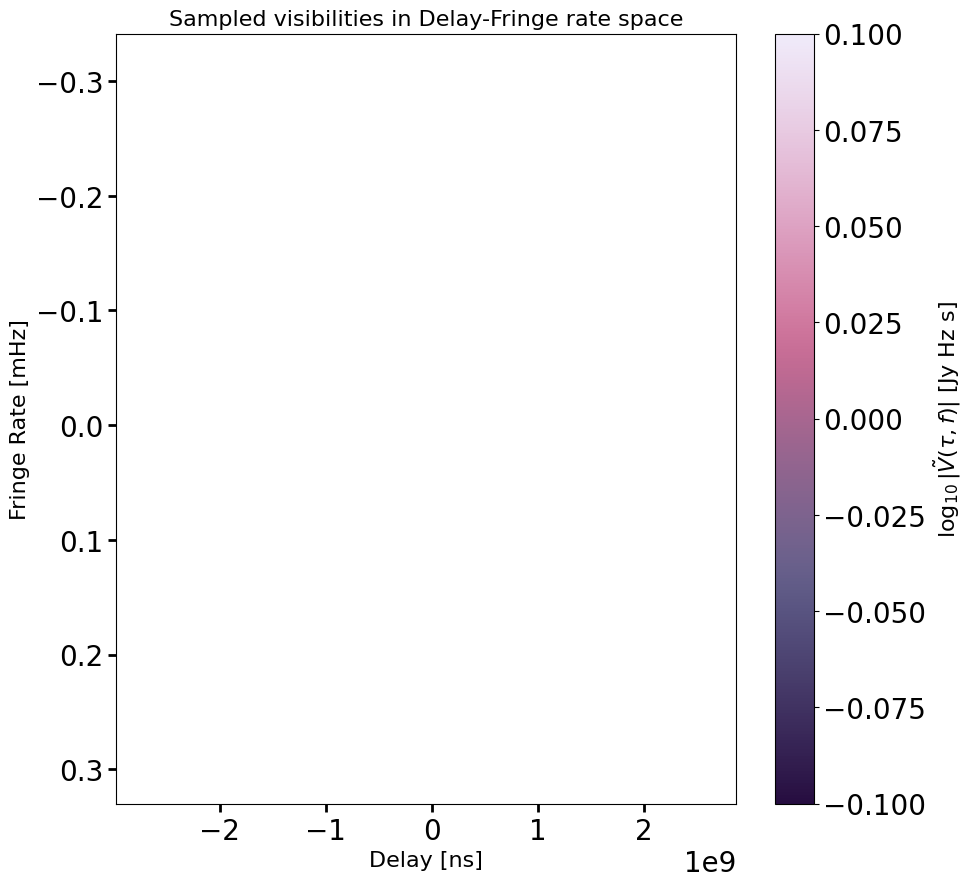

In [ ]:
sampled_dlfr=plot_waterfalls(model, freqs, lsts, windows='blackman-harris', mode='log', 
                    cmap=cmc.acton, dynamic_range=5, limit_drng='all',
                    baseline=None, horizon_color='magenta',
                    freq_window_kwargs=None, time_window_kwargs=None)
# plt.savefig('/Users/user/Documents/Codes/hydra_sys_project1/hydra-pspec-systematic-multiplicative/outputs/Sky data.png', transparent=True,
            # bbox_inches='tight',dpi=300)
plt.title("Sampled visibilities in Delay-Fringe rate space",fontsize=16)
# plt.savefig('/Users/user/Documents/Second_year_review/Images/figure_0a.png',bbox_inches='tight',dpi=300)

Text(0.5, 1.0, 'Residuals of DL-FR transform')

<Figure size 3200x3000 with 0 Axes>

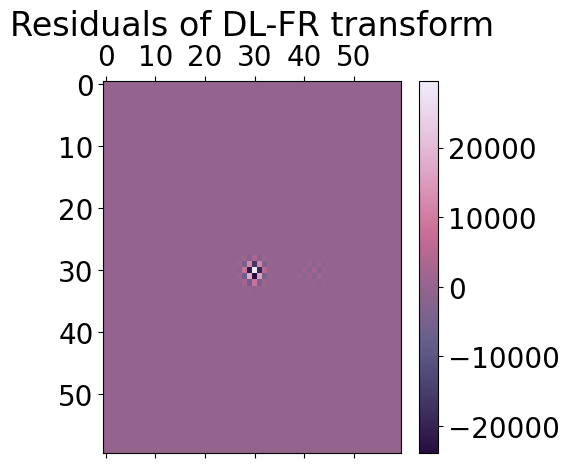

In [ ]:
plt.figure(figsize=(32,30))
plt.matshow((sampled_dlfr[1]-clean_dlfr[1]).real,aspect='auto',cmap=cmc.acton)
plt.colorbar()
plt.title('Residuals of DL-FR transform')

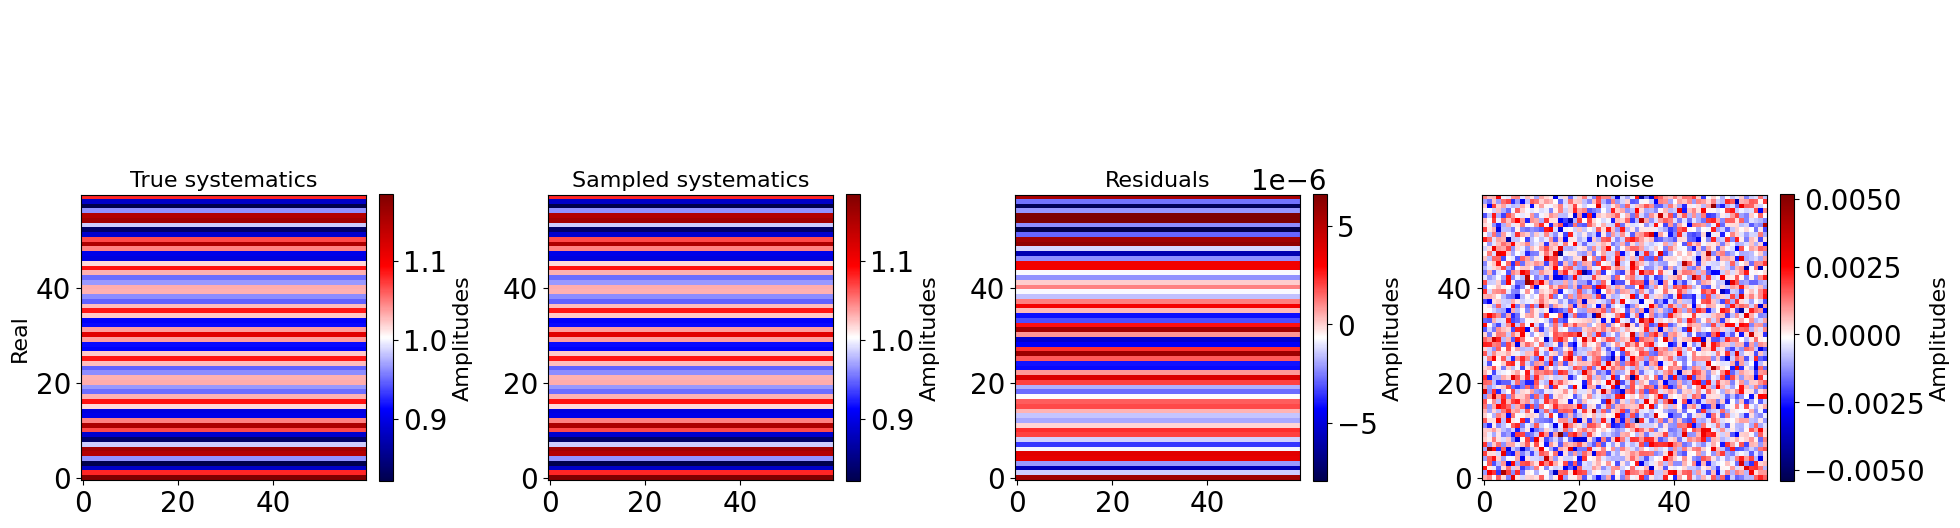

In [ ]:
master_plotter([sys_model_true,sys_model_sampled,sys_model_sampled-sys_model_true, n.T],col_labels=['True systematics','Sampled systematics','Residuals','noise'],fig_title=' ',save_flag=False,imag_flag=False)

In [ ]:
eor_res = eor_true[:Ntimes,:Nfreqs]-signal_amps
fg_res = fg_true[:Ntimes,:Nfreqs] - fg_amps @ fgmodes.T
sys_res = sys_model_true-sys_model_sampled

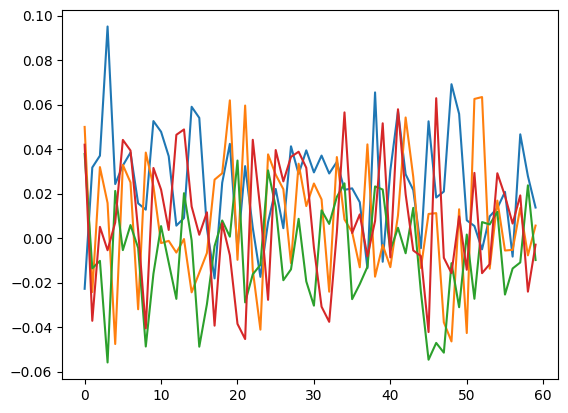

In [ ]:
for i in range(4):
    plt.plot(signal_amps[-1,i].real - eor_true.T[i].real)

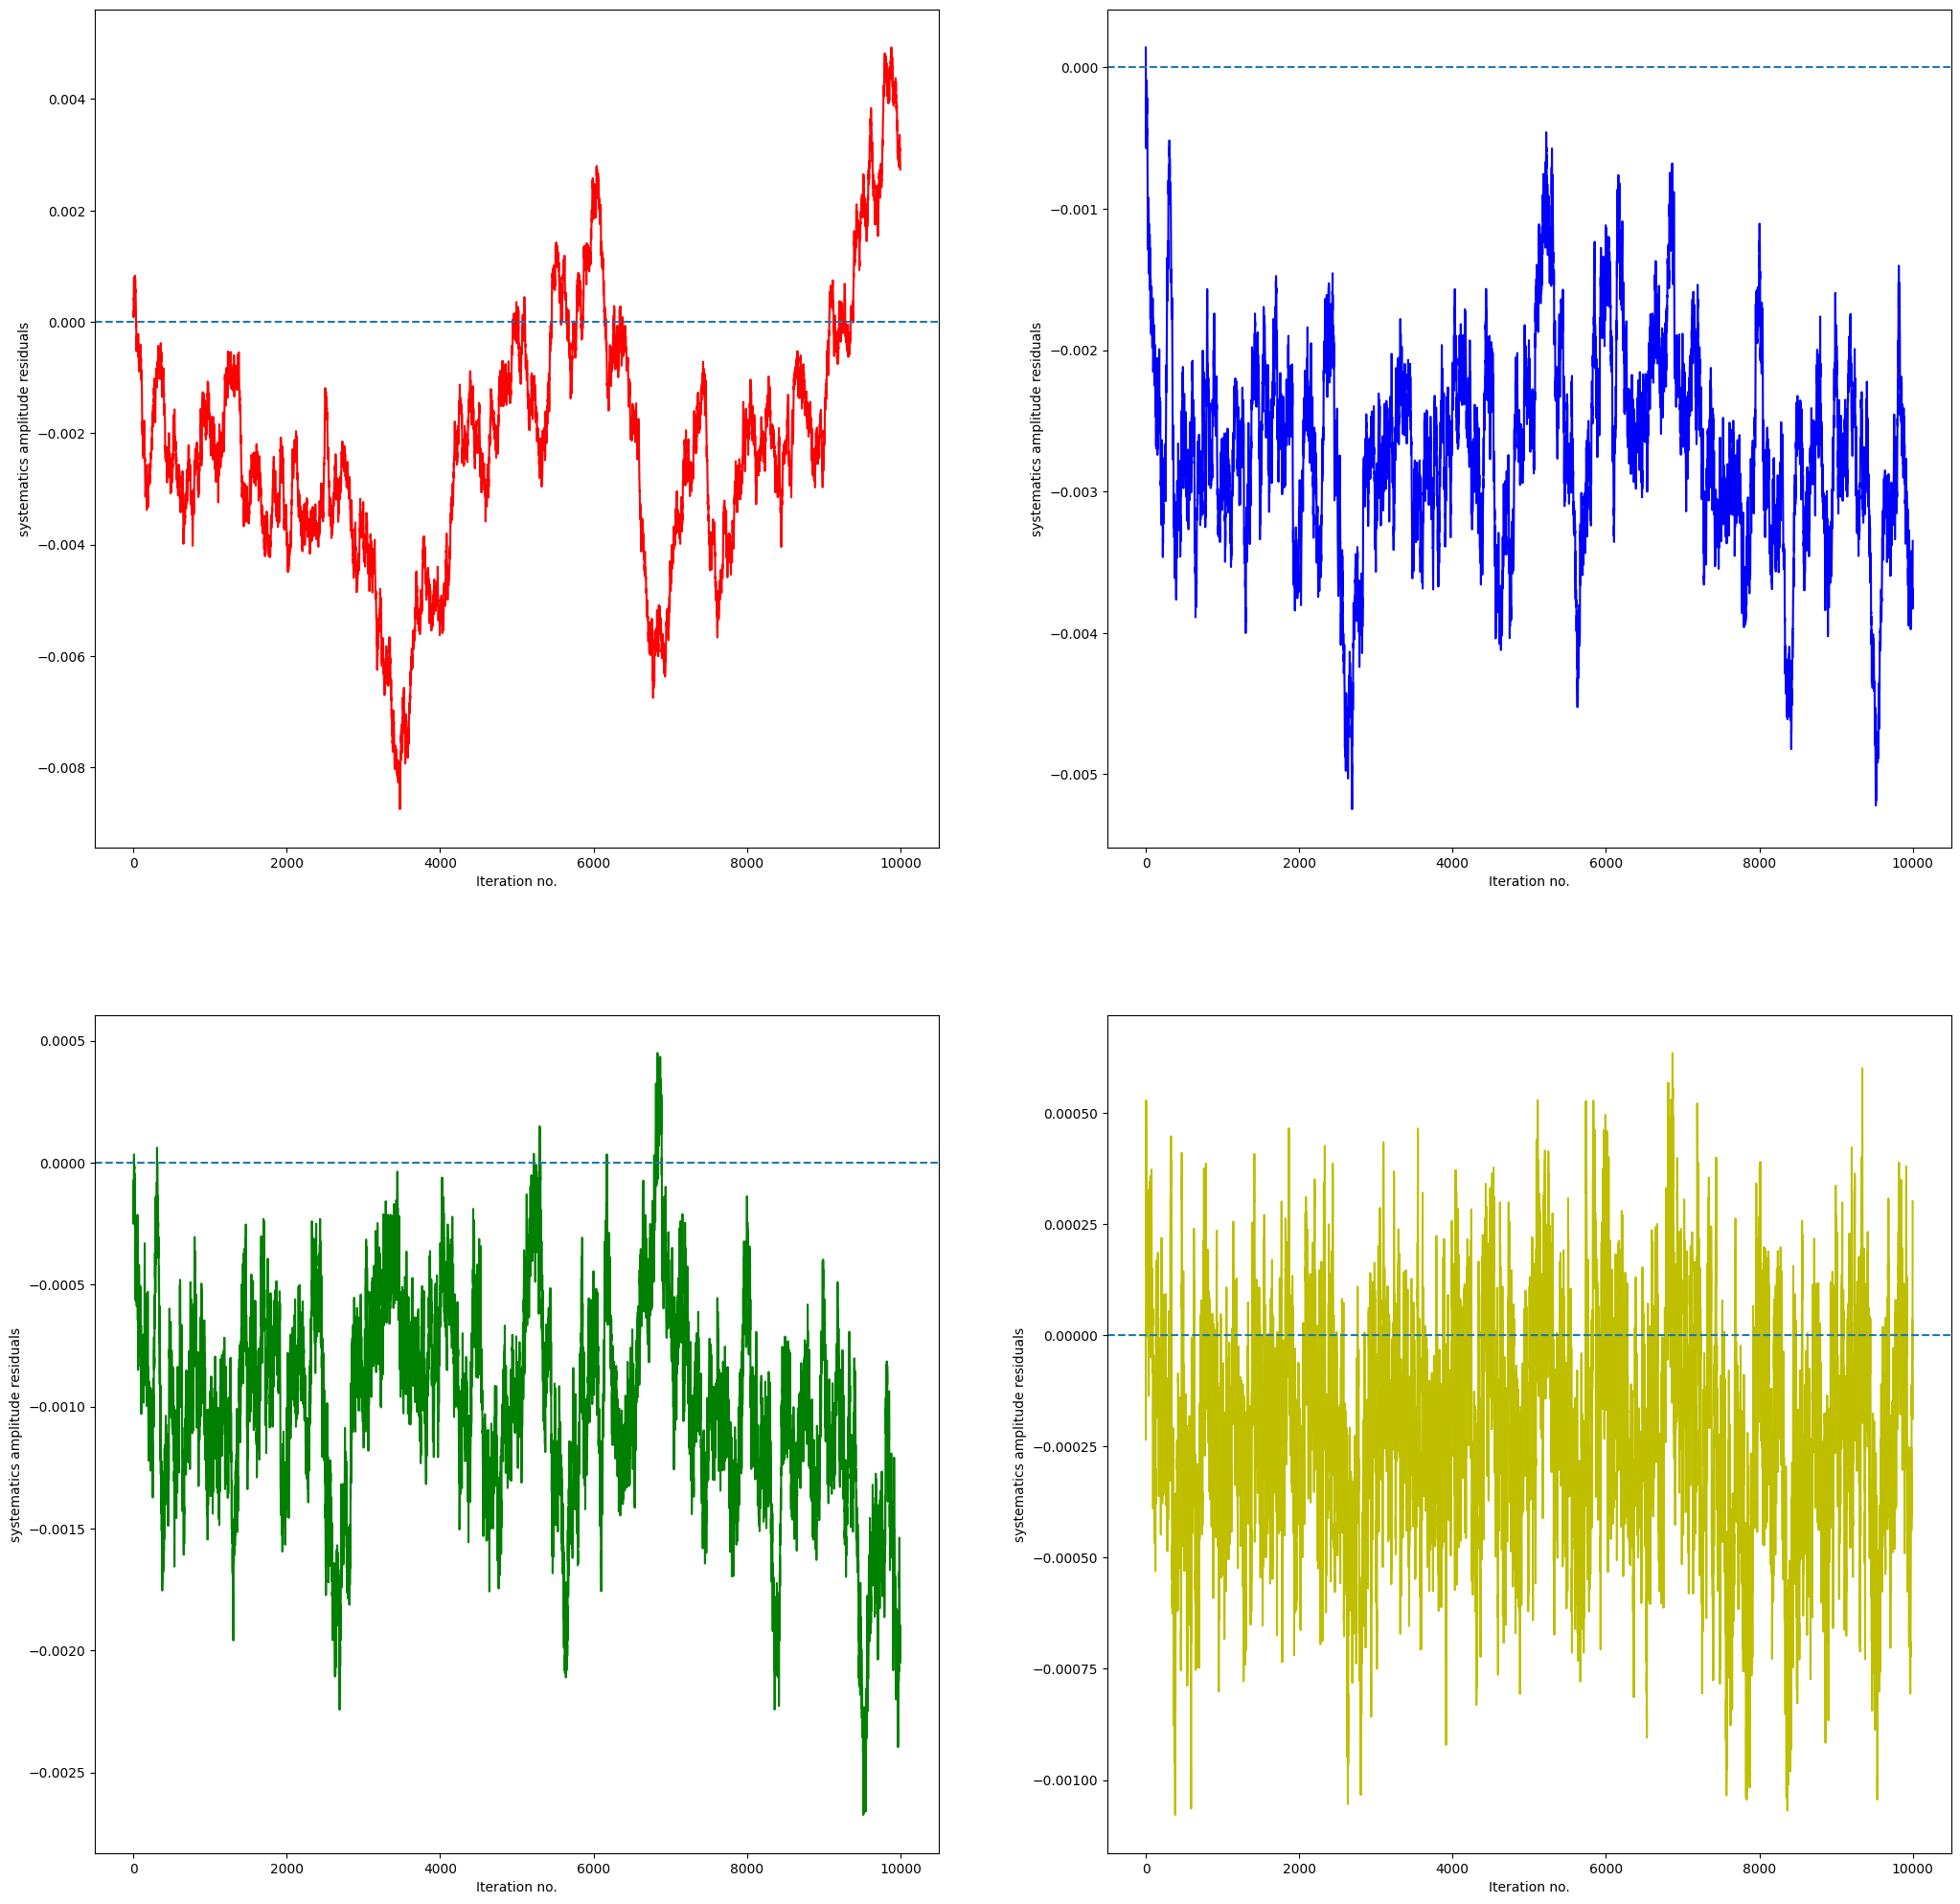

In [ ]:
sys_amps_true = np.array([4., 4.1, 5., -2.]) #np.array([4., 4.01])
sys_amps_complete = np.load(result_dir+run_version+'/b-sys.npy')

fig,axs=plt.subplots(2,2,figsize=(25,25))
colours = ['r', 'b', 'g', 'y', 'c', 'm']
for i,ax in enumerate(axs.flatten()):
    ax.plot(sys_amps_true[i].real-sys_amps_complete[:,i].real,c=colours[i])
    # plt.plot(fgmodes[:,1].real)
    ax.axhline(0,ls='dashed')
    ax.set_ylabel('systematics amplitude residuals')
    ax.set_xlabel('Iteration no.')

In [ ]:
signal_amps_complete.shape

(1000, 60)

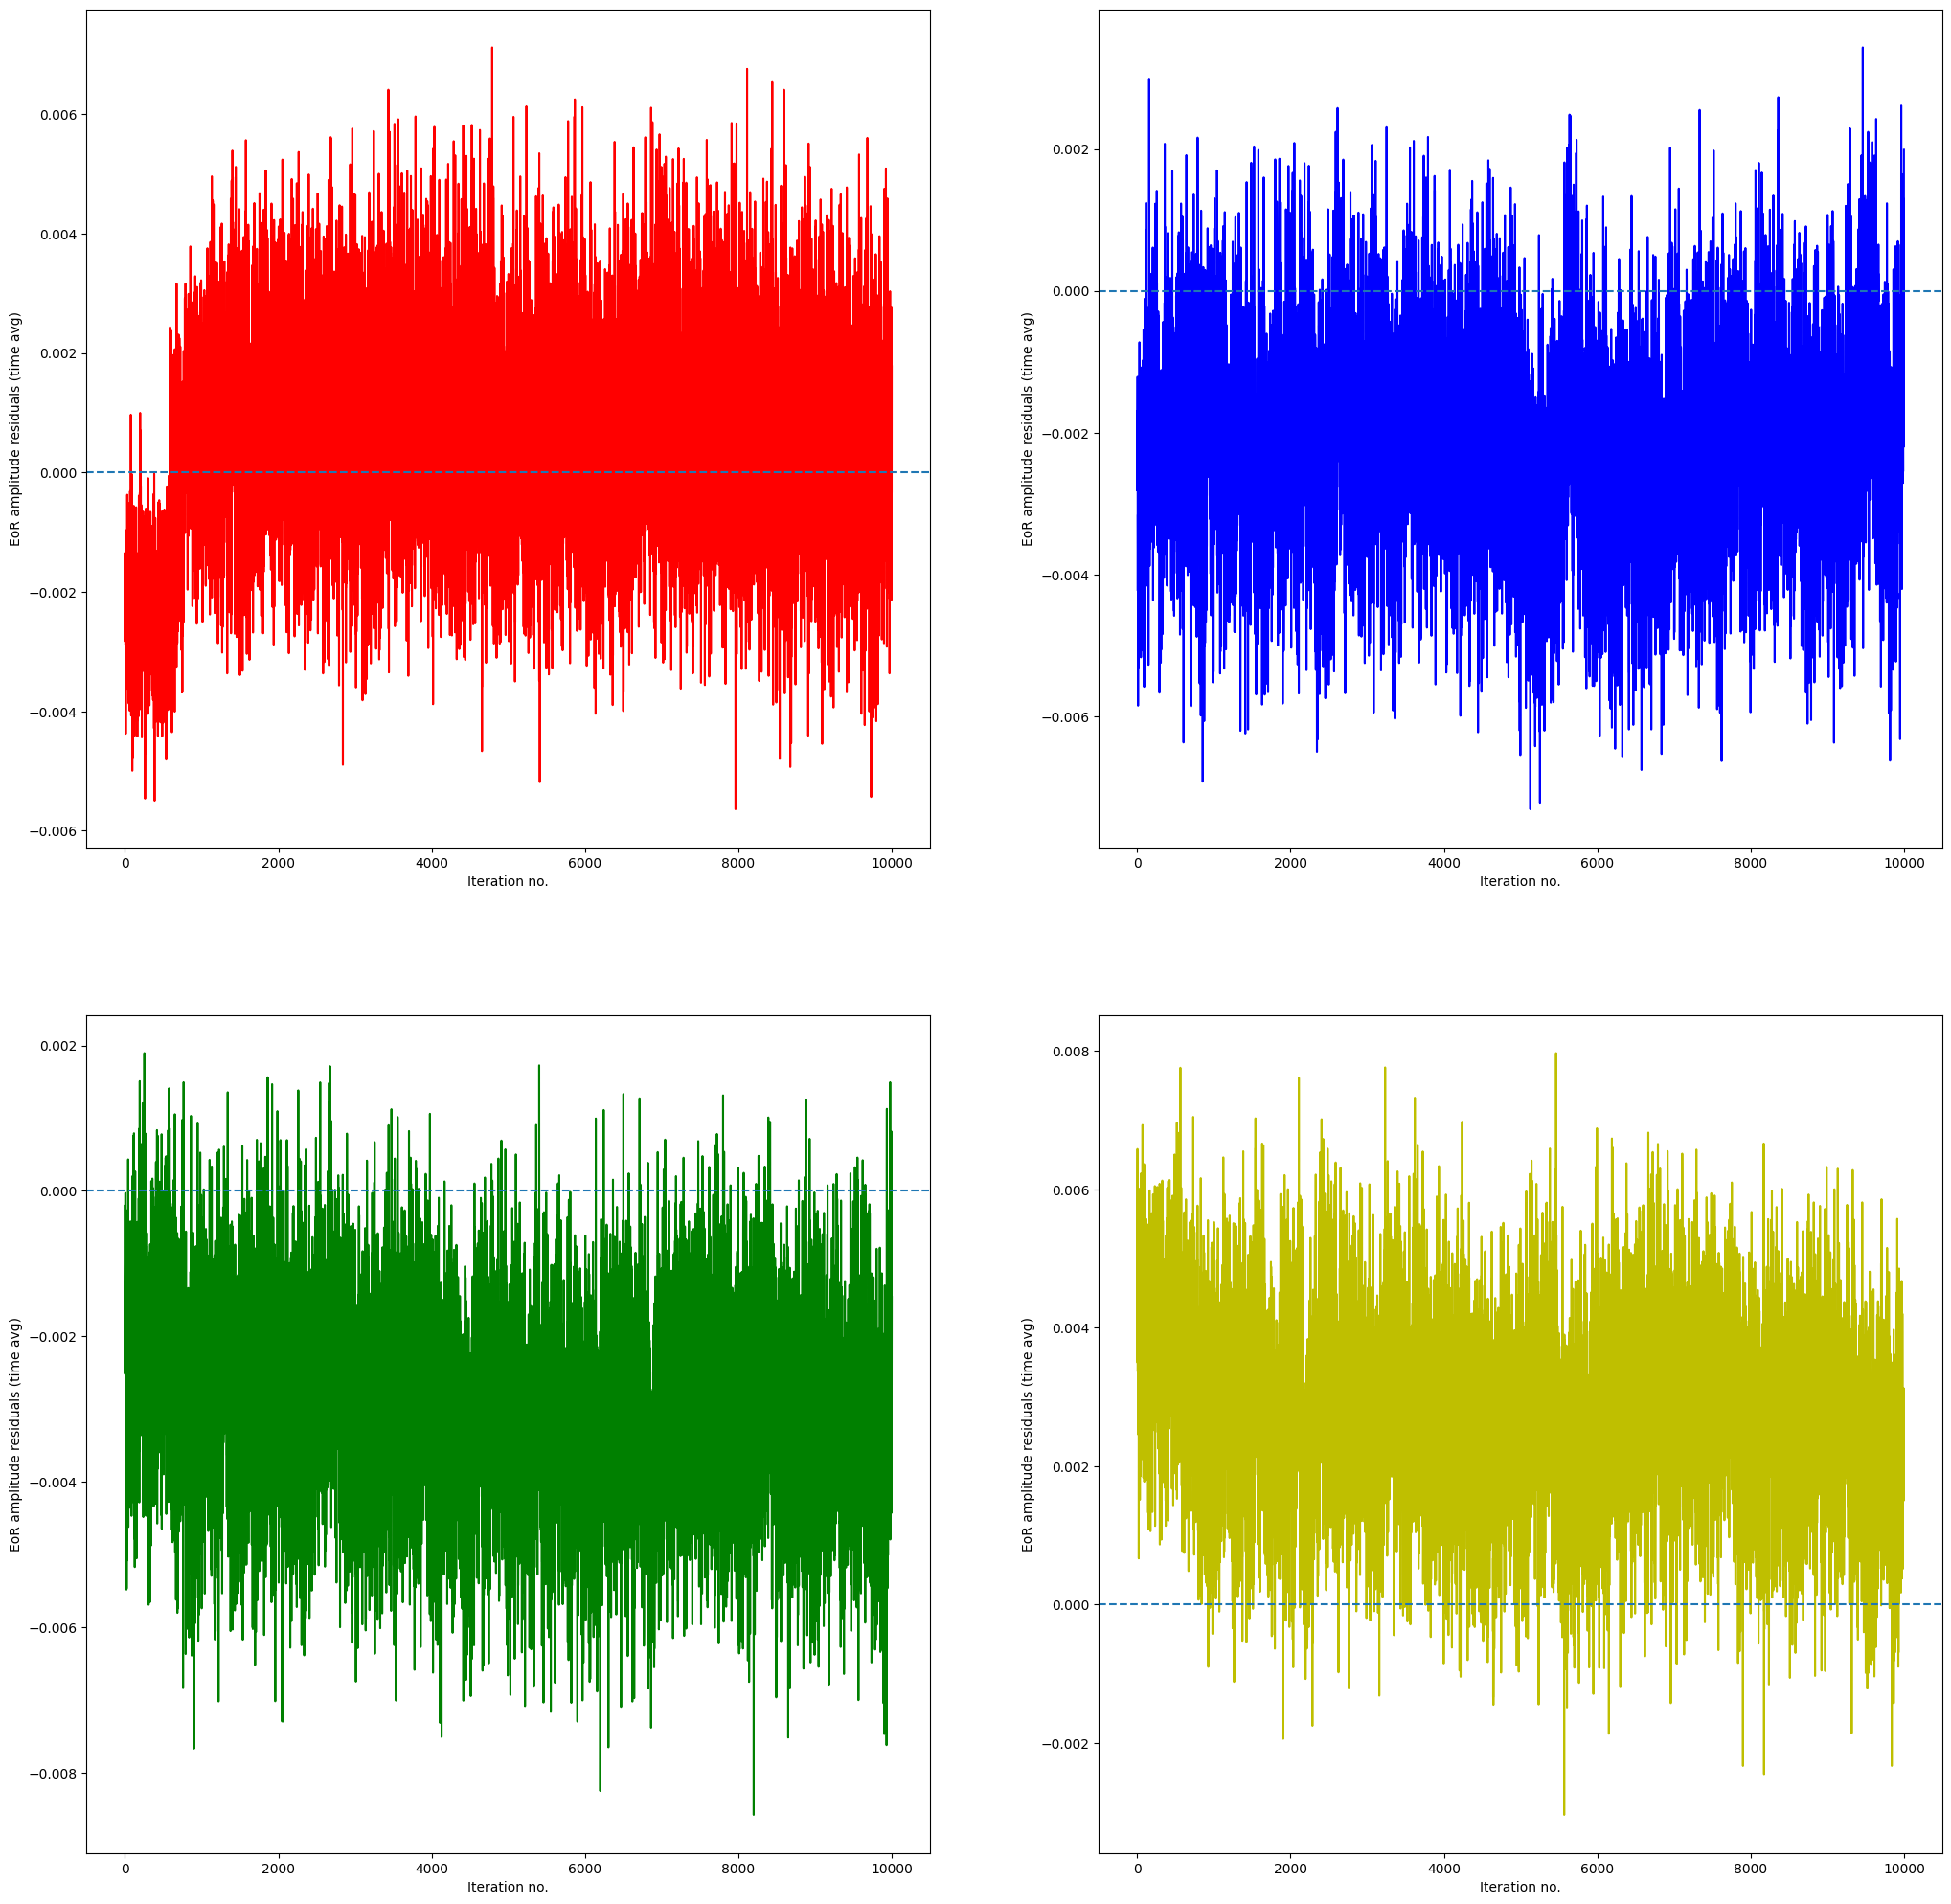

In [ ]:
signal_amps_complete = np.load(result_dir+run_version+'/gcr-eor.npy').mean(axis=1)

fig,axs=plt.subplots(2,2,figsize=(25,25))
colours = ['r', 'b', 'g', 'y', 'c', 'm']
for i,ax in enumerate(axs.flatten()):
    ax.plot(eor_true.mean(axis=1)[i].real-signal_amps_complete[:,i].real,c=colours[i])
    ax.axhline(0,ls='dashed')
    ax.set_ylabel('EoR amplitude residuals (time avg)')
    ax.set_xlabel('Iteration no.')

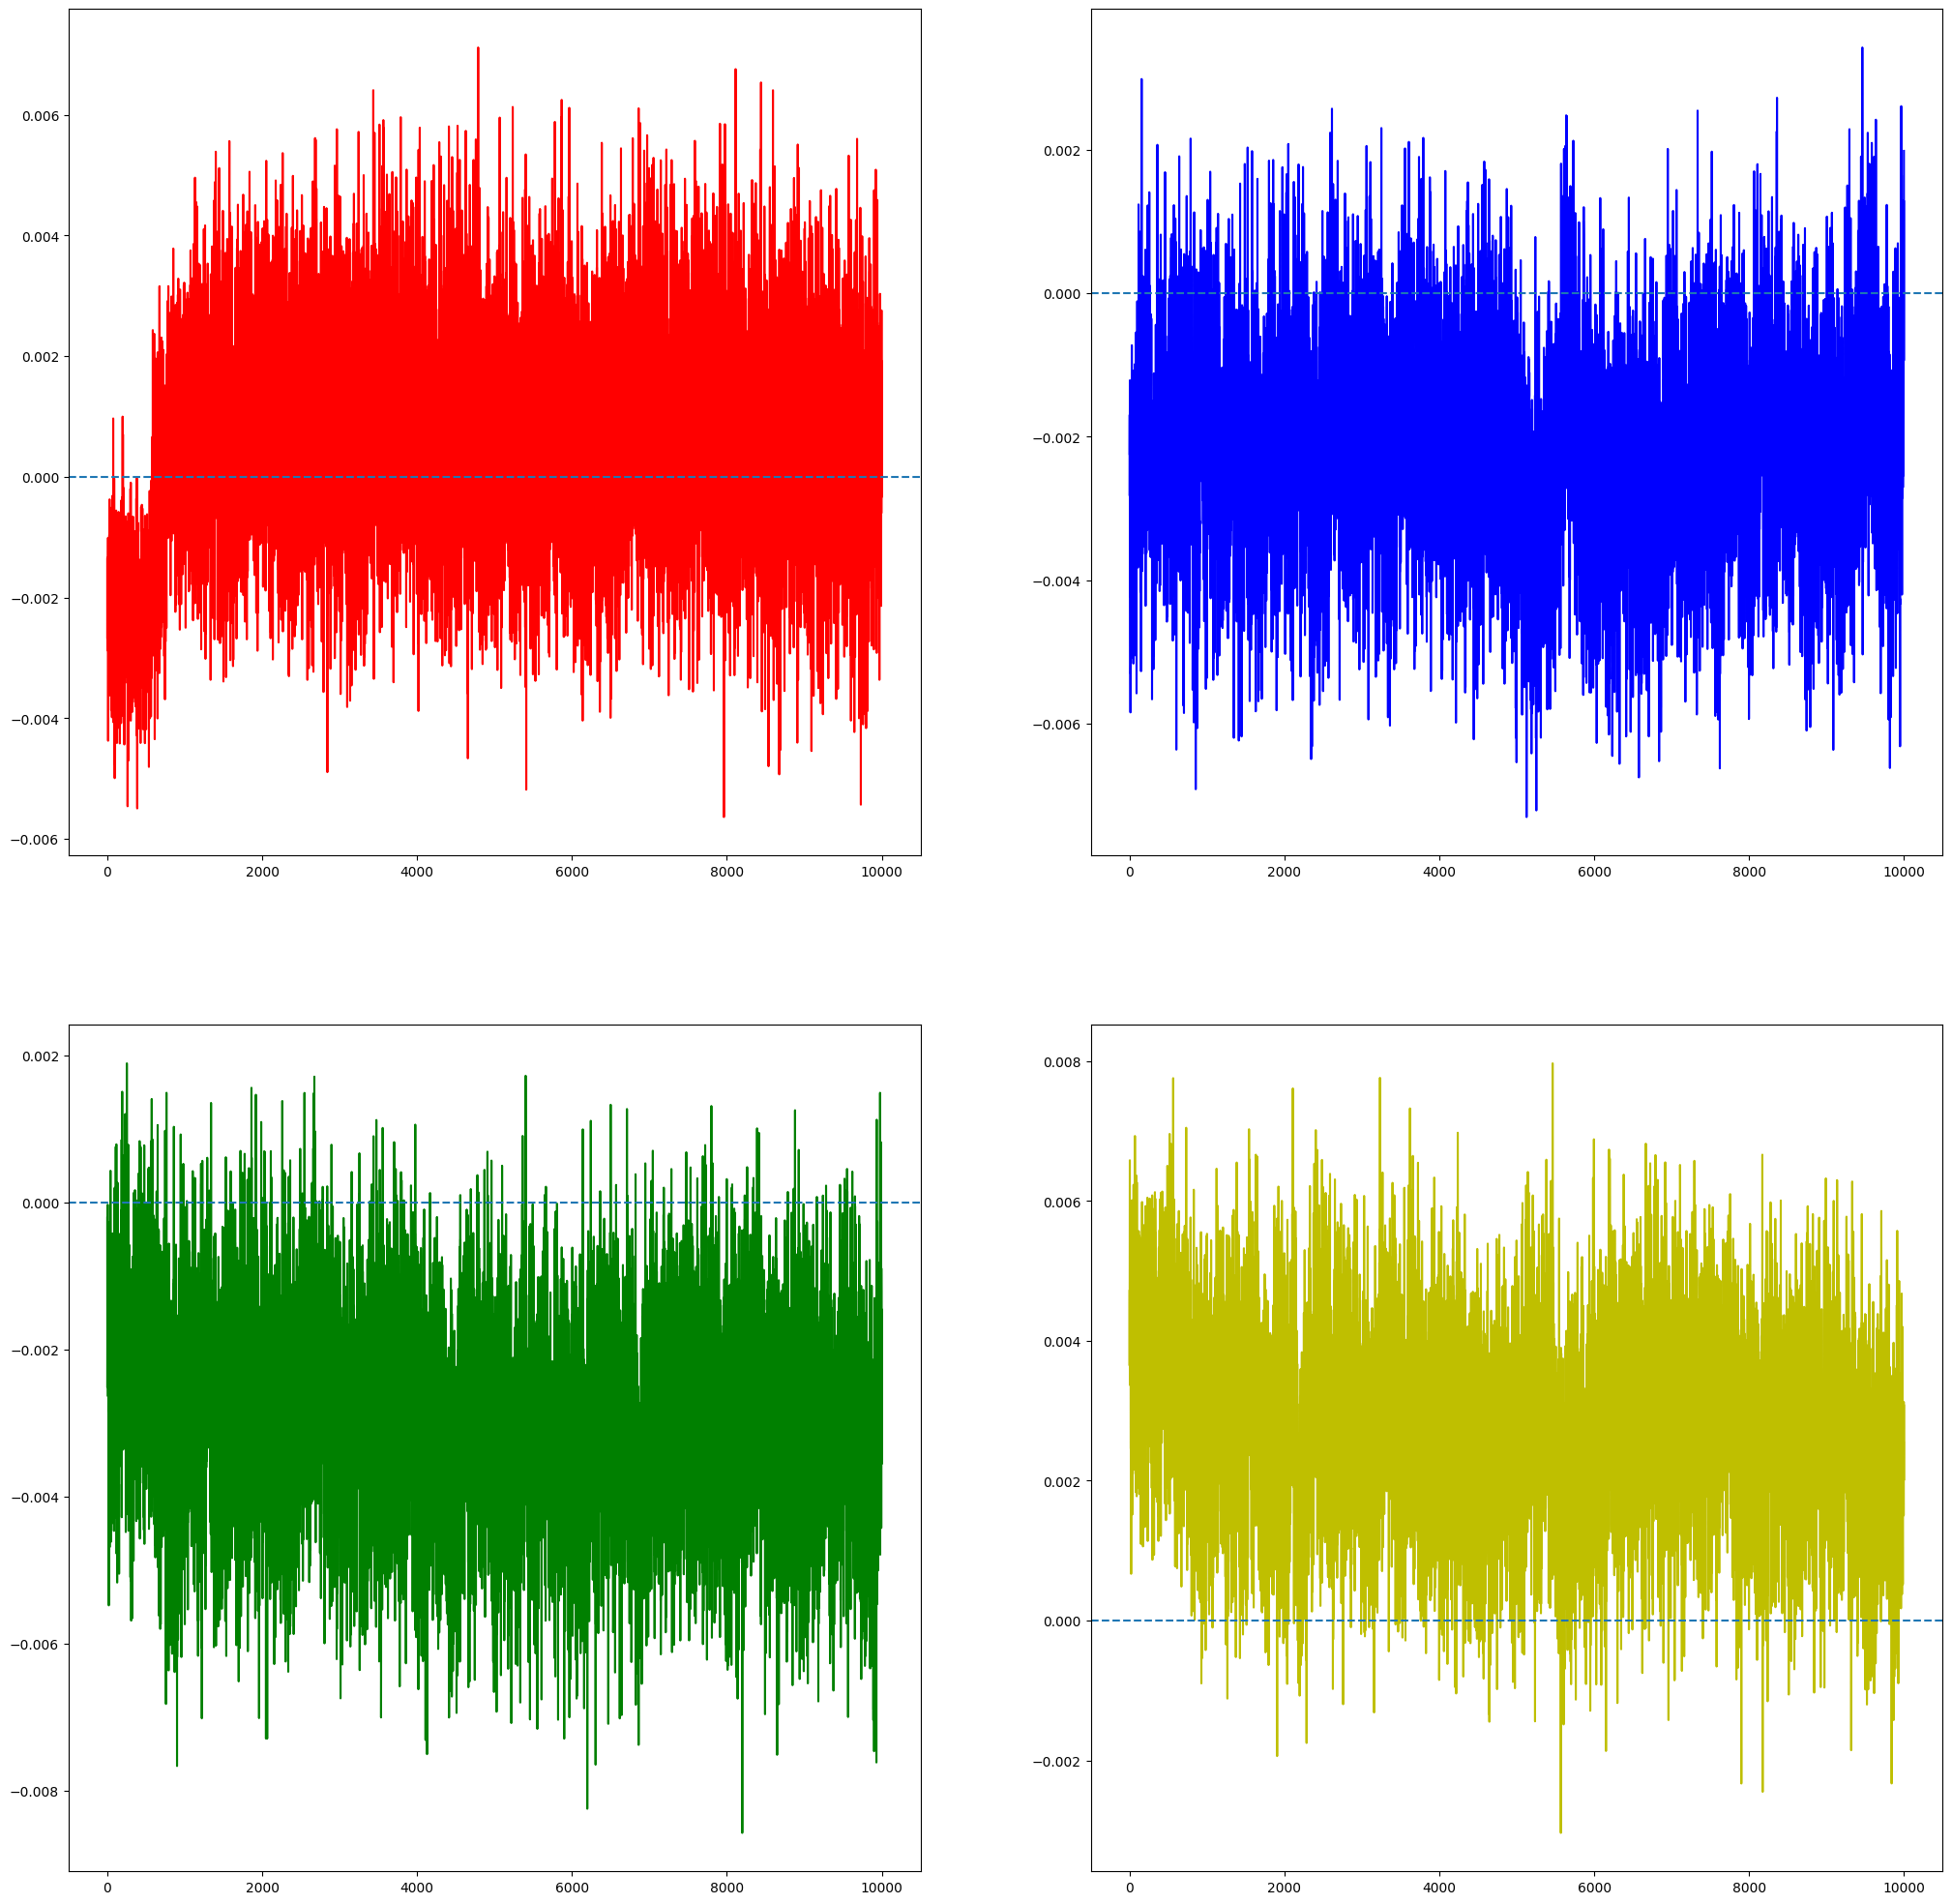

In [ ]:
fg_amps_complete = np.load(result_dir+run_version+'/gcr-eor.npy').mean(axis=1)

fig,axs=plt.subplots(2,2,figsize=(25,25))
colours = ['r', 'b', 'g', 'y', 'c', 'm']
for i,ax in enumerate(axs.flatten()):
    ax.plot(eor_true.mean(axis=1)[i].real-signal_amps_complete[:,i].real,c=colours[i])
    ax.axhline(0,ls='dashed')

divide by zero encountered in log10
invalid value encountered in scalar subtract


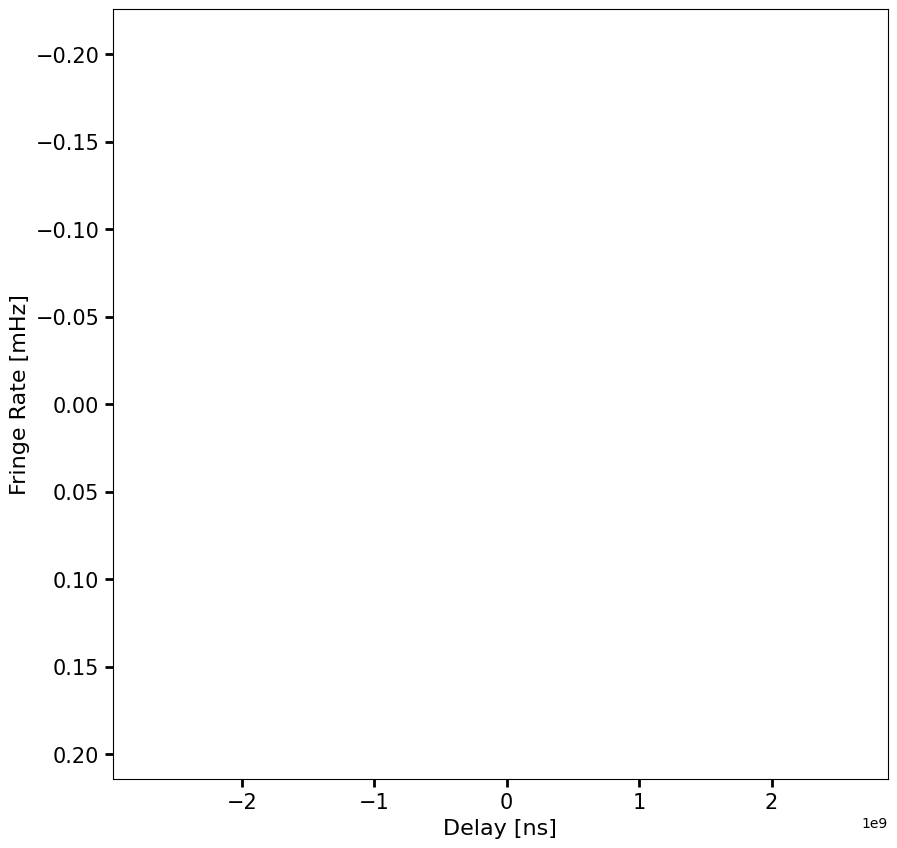

In [62]:
eor_true=np.load('/Users/user/Documents/Codes/hydra_sys_project1/multi_phil/hydra-pspec-systematic/paper_plots/fixed_sky/gcr-eor.npy')
freqs = np.linspace(100., 120., 120) ##120) 
freqs=freqs[:60]
lsts = np.linspace(0., 1., 40)


eor_dlfr_test=plot_waterfalls(eor_true.mean(axis=0), freqs, lsts, windows='blackman-harris', mode='log', 
                    cmap=cmc.acton, dynamic_range=5, limit_drng='all',
                    baseline=None, horizon_color='magenta',
                    freq_window_kwargs=None, time_window_kwargs=None)

In [64]:
eor_dlfr_test[1].shape

(40, 60)